# **Importing library&function**






In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, mean_squared_error, auc
from IPython.core.display import display, HTML
import numpy as np
import time
import os
from google.colab import drive
import itertools

!pip install split_folders
import splitfolders

!pip install scikit-learn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls /content/drive/MyDrive/ColabNotebooks/FinalProject/Dataset/grayscale/
import splitfolders
import os
loc = "/content/drive/MyDrive/ColabNotebooks/FinalProject/Dataset/grayscale/"
# csvloc = "/content/drive/MyDrive/ColabNotebooks/FinalProject/Result/"

gray_cataract  gray_diabetic_retinopathy  gray_glaucoma  gray_normal


In [4]:
import os
splitfolders.ratio(loc,output = "outputgrayscale",ratio = (0.80,0.10,0.10))
for dirpath,dirname,filename in os.walk("./outputgrayscale"):
  print(f"There are {len(dirname)} directories and {len(filename)} images in '{dirpath}'.")

Copying files: 4238 files [01:04, 65.68 files/s] 

There are 3 directories and 0 images in './outputgrayscale'.
There are 4 directories and 0 images in './outputgrayscale/test'.
There are 0 directories and 108 images in './outputgrayscale/test/gray_normal'.
There are 0 directories and 111 images in './outputgrayscale/test/gray_diabetic_retinopathy'.
There are 0 directories and 103 images in './outputgrayscale/test/gray_glaucoma'.
There are 0 directories and 106 images in './outputgrayscale/test/gray_cataract'.
There are 4 directories and 0 images in './outputgrayscale/train'.
There are 0 directories and 859 images in './outputgrayscale/train/gray_normal'.
There are 0 directories and 879 images in './outputgrayscale/train/gray_diabetic_retinopathy'.
There are 0 directories and 813 images in './outputgrayscale/train/gray_glaucoma'.
There are 0 directories and 838 images in './outputgrayscale/train/gray_cataract'.
There are 4 directories and 0 images in './outputgrayscale/val'.
There are 0 directories and 107 images in './outputgrayscale/

In [5]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 6,
                                             min_delta = 0.0001)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",factor = 0.2,
                                                patience = 4,min_lr = 1e-7)

In [6]:
data_aug = tf.keras.Sequential([
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomFlip("horizontal")
],name = "data_augmentation_layer")

In [7]:
def predict_labels(model, X_test):
    return model.predict(X_test)

def display_classification_report(y_test, y_pred):
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

def calculate_specificity(y_test, y_pred):
    # tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # specificity = tn / (tn + fp)
    # print(f"Specificity: {specificity}")
    cm = confusion_matrix(y_test, y_pred)
    specificity = []
    for i in range(cm.shape[0]):
      spec = cm[i, i] / (np.sum(cm[i, :]) - cm[i, i] + np.sum(cm[:, :]) - np.sum(cm[i, :]))
      specificity.append(spec)
    print(f"Specificity: {specificity}")

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize
    n_classes = cm.shape[0]  # find the number of classes

    specificity = []  # To store specificity values for each class

    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    ax.set(
        title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=labels,
        yticklabels=labels
    )

    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    plt.xticks(rotation=70, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    threshold = (cm.max() + cm.min()) / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        specificity_val = (cm.sum() - cm[i].sum() - cm[:, j].sum() + cm[i, j]) / (
            cm.sum() - cm[:, j].sum()
        )
        specificity.append(specificity_val)

        if norm:
            plt.text(
                j,
                i,
                f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%,\n {specificity_val*100:.1f}%)",
                #  f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%, Specificity: {specificity_val*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size,
            )
        else:
            plt.text(
                j,
                i,
                f"{cm[i, j]} ( {specificity_val*100:.1f}%)",
                #  f"{cm[i, j]} (Specificity: {specificity_val*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size,
            )

    if savefig:
        fig.savefig("confusion_matrix.png")

    return specificity

def calculate_mse(y_test, y_probs, n_classes):
  y_true_onehot = tf.keras.utils.to_categorical(y_test, n_classes)
  mse = mean_squared_error(y_true_onehot, y_probs)
  print(f"Mean Squared Error: : {mse}")
  return y_true_onehot

def calculate_roc_auc_score(y_test, y_probs):
  auc_roc = roc_auc_score(y_test, y_probs, multi_class='ovr', average=None)
  average_auc_roc = np.mean(auc_roc)
  print(f"The average AUC-ROC is {average_auc_roc}")

# **Batch size: 16**

In [8]:
epoch = 20
batchsize = 16

In [9]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir = "outputgrayscale/train"
test_dir =  "outputgrayscale/test"
val_dir = "outputgrayscale/val"

train_data = image_dataset_from_directory(train_dir, label_mode="categorical",
                                          image_size=(224, 224), batch_size=batchsize,
                                          shuffle=True, seed=42, color_mode='grayscale')

test_data = image_dataset_from_directory(test_dir, label_mode="categorical",
                                         image_size=(224, 224), batch_size=batchsize,
                                         shuffle=False, seed=42, color_mode='grayscale')

val_data = image_dataset_from_directory(val_dir, label_mode="categorical",
                                        image_size=(224, 224), batch_size=batchsize,
                                        shuffle=False, seed=42, color_mode='grayscale')


Found 3389 files belonging to 4 classes.
Found 428 files belonging to 4 classes.
Found 421 files belonging to 4 classes.


# **EfficientNetV2B3 Model**

In [10]:
efficient_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
efficient_model.trainable = False


52606240/52606240 [==============================] - 0s 0us/step


In [11]:
inputs = layers.Input(shape=(224, 224, 1), name="input_layer")
x = data_aug(inputs)
# x = inputs
x = efficient_model(x)

# Apply Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dense(4)(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

efficient_model = tf.keras.Model(inputs, outputs)
efficient_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 1)]     0         
                                                                 
 data_augmentation_layer (S  (None, None, None, 1)     0         
 equential)                                                      
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 32)                49184     
                                                             

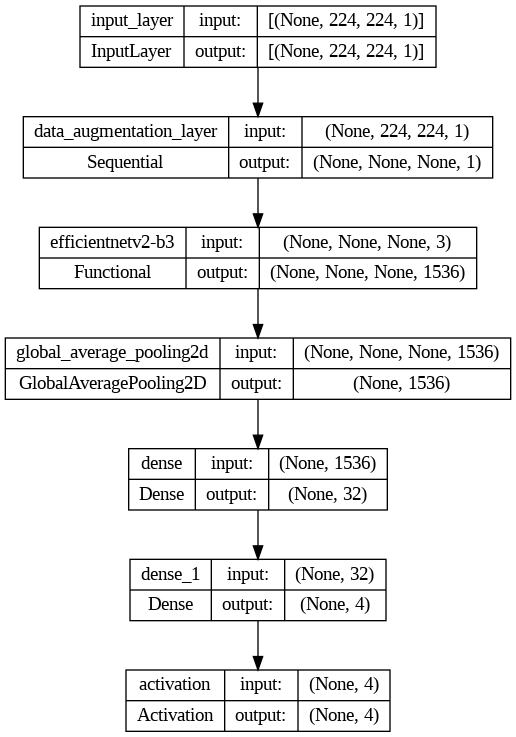

In [12]:
tf.keras.utils.plot_model(efficient_model, show_shapes=True)

In [13]:
efficient_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [14]:
efficient_history = efficient_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
212/212 [==============================] - 79s 279ms/step - loss: 0.7217 - accuracy: 0.7008 - val_loss: 0.6860 - val_accuracy: 0.7221 - lr: 0.0010
Epoch 2/20
212/212 [==============================] - 47s 221ms/step - loss: 0.5679 - accuracy: 0.7757 - val_loss: 0.6472 - val_accuracy: 0.7435 - lr: 0.0010
Epoch 3/20
212/212 [==============================] - 41s 193ms/step - loss: 0.5301 - accuracy: 0.7932 - val_loss: 0.7123 - val_accuracy: 0.6936 - lr: 0.0010
Epoch 4/20
212/212 [==============================] - 40s 186ms/step - loss: 0.4997 - accuracy: 0.8023 - val_loss: 0.6560 - val_accuracy: 0.7577 - lr: 0.0010
Epoch 5/20
212/212 [==============================] - 34s 161ms/step - loss: 0.4810 - accuracy: 0.8038 - val_loss: 0.6797 - val_accuracy: 0.7601 - lr: 0.0010
Epoch 6/20
212/212 [==============================] - 32s 152ms/step - loss: 0.4773 - accuracy: 0.8162 - val_loss: 0.6127 - val_accuracy: 0.7553 - lr: 0.0010
Epoch 7/20
212/212 [==============================] 

EfficientNetV2B3 Evaluation

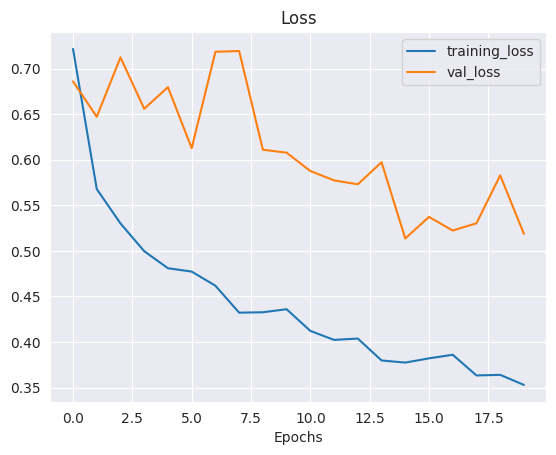

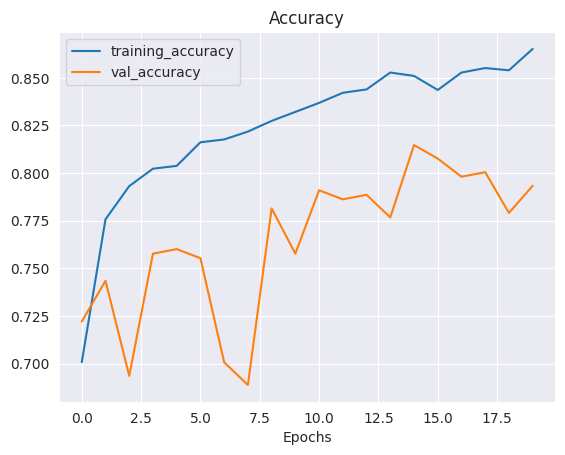

In [15]:
plot_loss_curves(efficient_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 1s 41ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       106
           1       0.84      0.93      0.88       111
           2       0.91      0.65      0.76       103
           3       0.76      0.87      0.81       108

    accuracy                           0.85       428
   macro avg       0.86      0.85      0.84       428
weighted avg       0.86      0.85      0.85       428

Specificity: [0.3009118541033435, 0.3169230769230769, 0.18559556786703602, 0.281437125748503]
Mean Squared Error: : 0.1232249066233635
The average AUC-ROC is 0.9714761708539852


[0.978125,
 0.6535947712418301,
 0.7062146892655368,
 0.6677631578947368,
 0.653125,
 0.9738562091503268,
 0.692090395480226,
 0.6546052631578947,
 0.703125,
 0.6928104575163399,
 0.8983050847457628,
 0.7236842105263158,
 0.665625,
 0.6797385620915033,
 0.7033898305084746,
 0.9539473684210527]

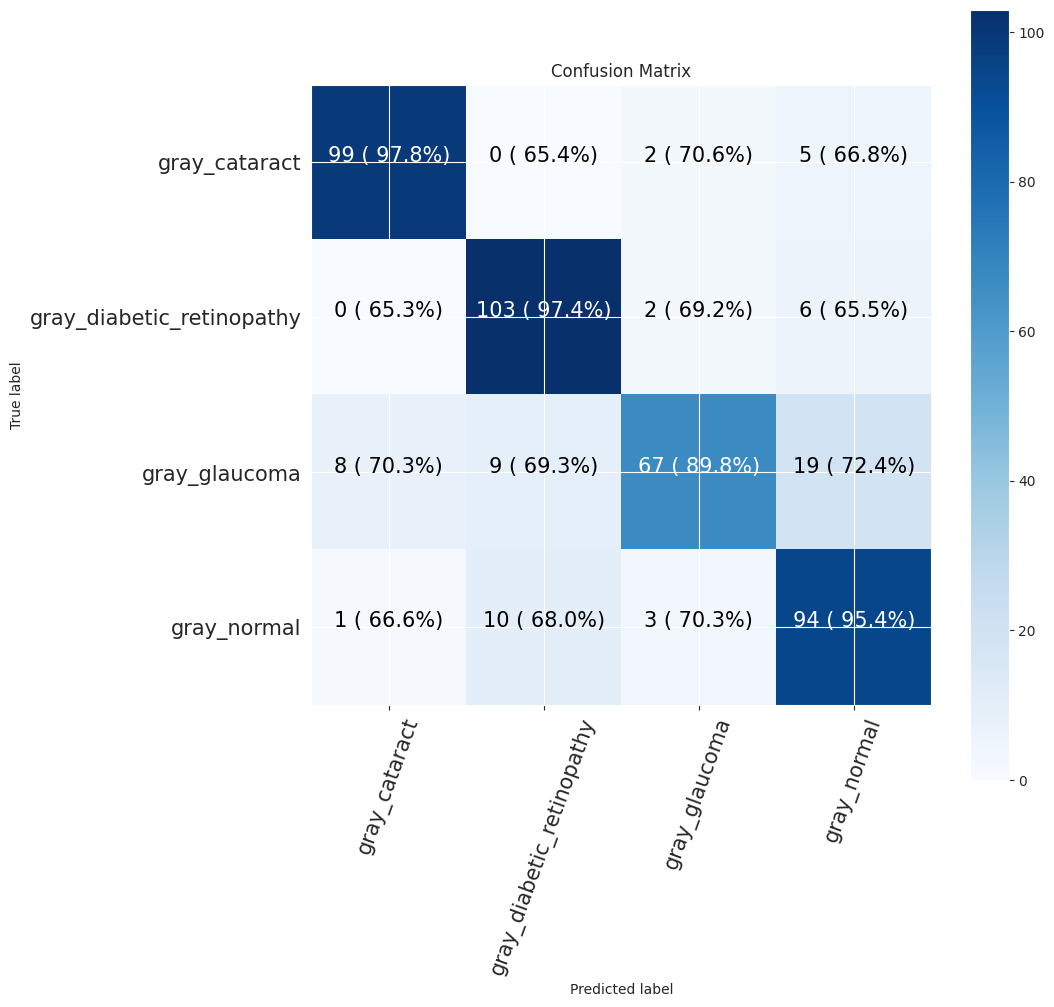

In [16]:
# Save Model
efficient_model.save("efficient_model.h5")

model = efficient_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


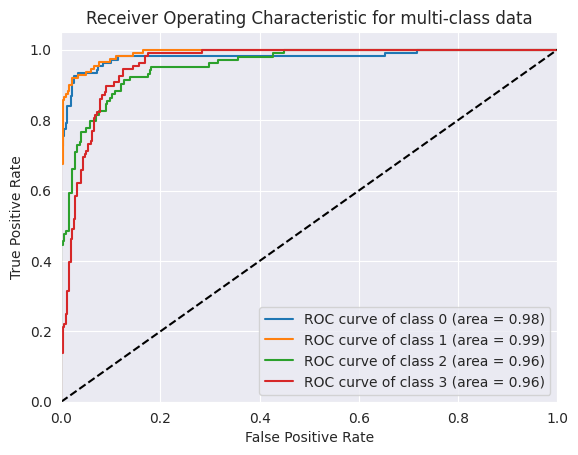

In [17]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **CNN model**

In [18]:

from tensorflow.keras.models import Sequential

# Create a Sequential model
cnn_model = Sequential()

# Add convolutional layers for feature extraction
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))  # Grayscale image has 1 channel

# Freeze the layers in the base model
for layer in cnn_model.layers:
    layer.trainable = False

grayscale_input = layers.Input(shape=(224, 224, 1))

grayscale_input = data_aug(grayscale_input)

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for dense layers
cnn_model.add(layers.Flatten())

# Add dense layers for classification
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dense(4, activation='softmax'))  # Set num_classes to your specific number of classes

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

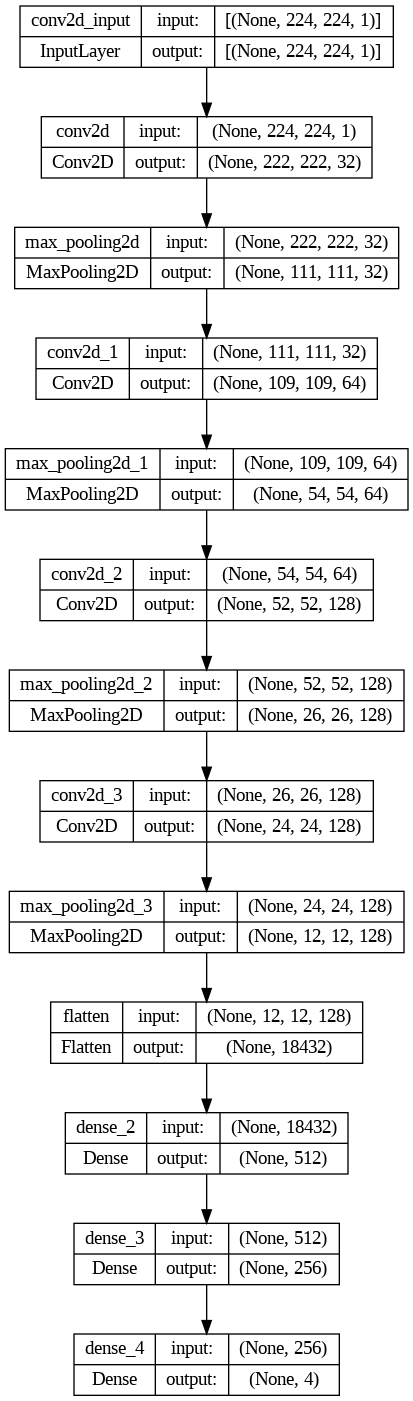

In [19]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [20]:
cnn_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [21]:
cnn_history = cnn_model.fit(train_data,epochs = epoch, validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
212/212 [==============================] - 9s 23ms/step - loss: 1.7048 - accuracy: 0.5727 - val_loss: 0.8262 - val_accuracy: 0.6366 - lr: 0.0010
Epoch 2/20
212/212 [==============================] - 4s 20ms/step - loss: 0.6637 - accuracy: 0.6967 - val_loss: 0.6350 - val_accuracy: 0.7150 - lr: 0.0010
Epoch 3/20
212/212 [==============================] - 4s 20ms/step - loss: 0.6083 - accuracy: 0.7262 - val_loss: 0.6611 - val_accuracy: 0.7173 - lr: 0.0010
Epoch 4/20
212/212 [==============================] - 4s 20ms/step - loss: 0.5732 - accuracy: 0.7374 - val_loss: 0.6827 - val_accuracy: 0.7245 - lr: 0.0010
Epoch 5/20
212/212 [==============================] - 4s 20ms/step - loss: 0.6559 - accuracy: 0.7170 - val_loss: 0.6754 - val_accuracy: 0.7173 - lr: 0.0010
Epoch 6/20
212/212 [==============================] - 4s 21ms/step - loss: 0.6268 - accuracy: 0.7197 - val_loss: 0.6671 - val_accuracy: 0.7007 - lr: 0.0010
Epoch 7/20
212/212 [==============================] - 4s 21ms/st

CNN Evaluation

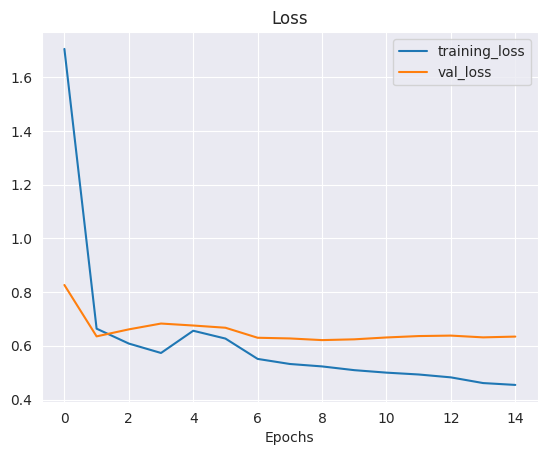

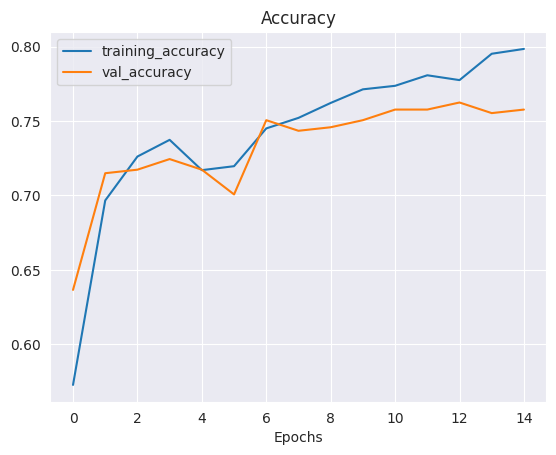

In [22]:
plot_loss_curves(cnn_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 0s 7ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.62      0.61       106
           1       1.00      1.00      1.00       111
           2       0.62      0.43      0.51       103
           3       0.73      0.92      0.81       108

    accuracy                           0.75       428
   macro avg       0.74      0.74      0.73       428
weighted avg       0.74      0.75      0.74       428

Specificity: [0.18232044198895028, 0.3501577287066246, 0.11458333333333333, 0.3009118541033435]
Mean Squared Error: : 0.13529378175735474
The average AUC-ROC is 0.9056278249729705


[0.8742138364779874,
 0.6656151419558359,
 0.7647058823529411,
 0.6986301369863014,
 0.6509433962264151,
 1.0,
 0.6890756302521008,
 0.6198630136986302,
 0.8018867924528302,
 0.6750788643533123,
 0.834733893557423,
 0.7123287671232876,
 0.6729559748427673,
 0.6593059936908517,
 0.711484593837535,
 0.9691780821917808]

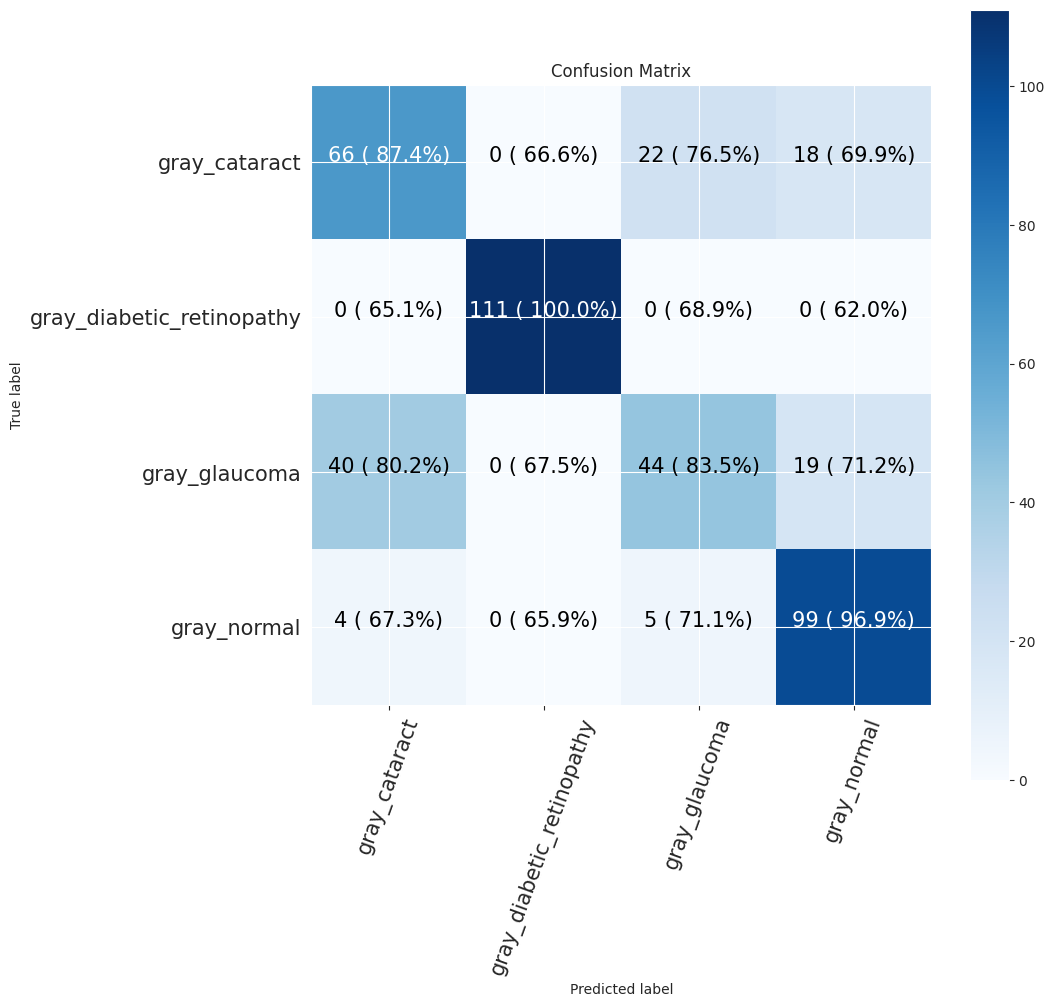

In [23]:
# Save Model
cnn_model.save("cnn_model.h5")

model = cnn_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


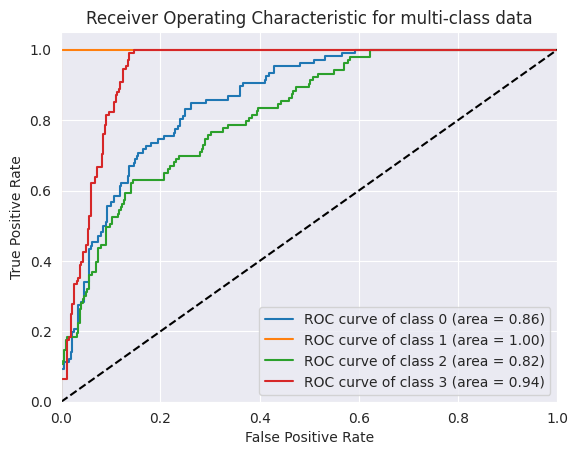

In [24]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet50 Model**



In [25]:
from tensorflow.keras.applications import ResNet50

# Load ResNet-50 without the top classification layers (include_top=False)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet50_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)
# Convert grayscale to 3 channels (matching the input requirement of ResNet-50)
conv_layer = Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-50 model
x = resnet50_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-50 model for grayscale images
resnet50_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet50_model.summary()


94765736/94765736 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 3)     30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_5 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_6 (Dense)             (None, 4)                 4100 

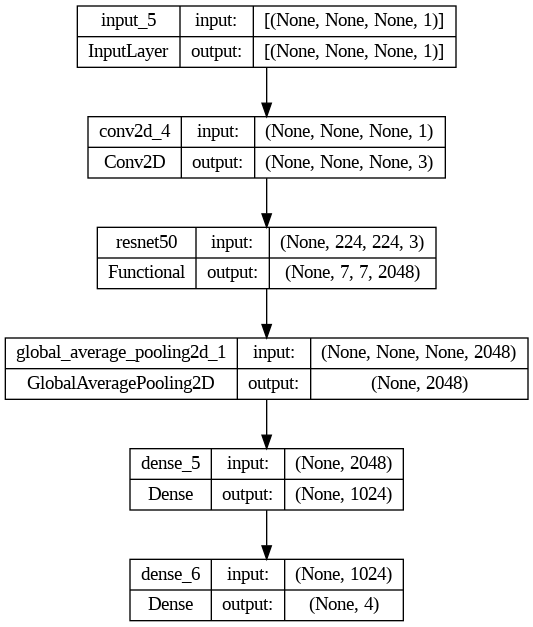

In [26]:
tf.keras.utils.plot_model(resnet50_model, show_shapes=True)

In [27]:
resnet50_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [28]:
resnet50_history = resnet50_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
212/212 [==============================] - 37s 149ms/step - loss: 0.6675 - accuracy: 0.7678 - val_loss: 0.4824 - val_accuracy: 0.7791 - lr: 0.0010
Epoch 2/20
212/212 [==============================] - 29s 137ms/step - loss: 0.3846 - accuracy: 0.8510 - val_loss: 0.3060 - val_accuracy: 0.8741 - lr: 0.0010
Epoch 3/20
212/212 [==============================] - 29s 136ms/step - loss: 0.3125 - accuracy: 0.8775 - val_loss: 0.3181 - val_accuracy: 0.8860 - lr: 0.0010
Epoch 4/20
212/212 [==============================] - 29s 136ms/step - loss: 0.2825 - accuracy: 0.8864 - val_loss: 0.3482 - val_accuracy: 0.8717 - lr: 0.0010
Epoch 5/20
212/212 [==============================] - 29s 137ms/step - loss: 0.2561 - accuracy: 0.9047 - val_loss: 0.2485 - val_accuracy: 0.9145 - lr: 0.0010
Epoch 6/20
212/212 [==============================] - 29s 137ms/step - loss: 0.2595 - accuracy: 0.8941 - val_loss: 0.2619 - val_accuracy: 0.9097 - lr: 0.0010
Epoch 7/20
212/212 [==============================] 

ResNet50 Evaluation

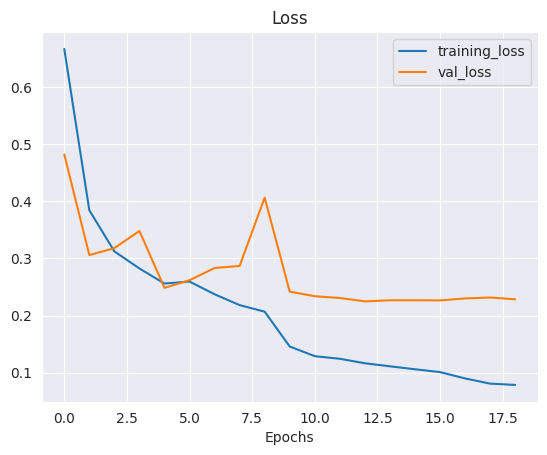

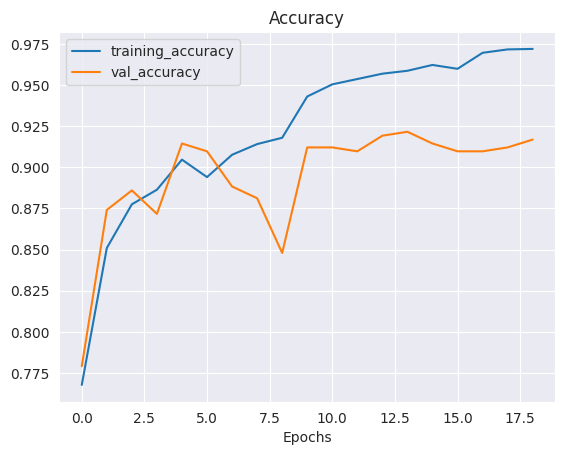

In [29]:
plot_loss_curves(resnet50_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 1s 48ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.91       106
           1       1.00      1.00      1.00       111
           2       0.89      0.84      0.87       103
           3       0.90      0.89      0.89       108

    accuracy                           0.92       428
   macro avg       0.92      0.92      0.92       428
weighted avg       0.92      0.92      0.92       428

Specificity: [0.3009118541033435, 0.3501577287066246, 0.25513196480938416, 0.2891566265060241]
Mean Squared Error: : 0.10671959817409515
The average AUC-ROC is 0.9879126043060912


[0.9778481012658228,
 0.6656151419558359,
 0.6878787878787879,
 0.6822429906542056,
 0.6487341772151899,
 1.0,
 0.6636363636363637,
 0.6542056074766355,
 0.7025316455696202,
 0.6750788643533123,
 0.9515151515151515,
 0.7009345794392523,
 0.6708860759493671,
 0.6593059936908517,
 0.696969696969697,
 0.9626168224299065]

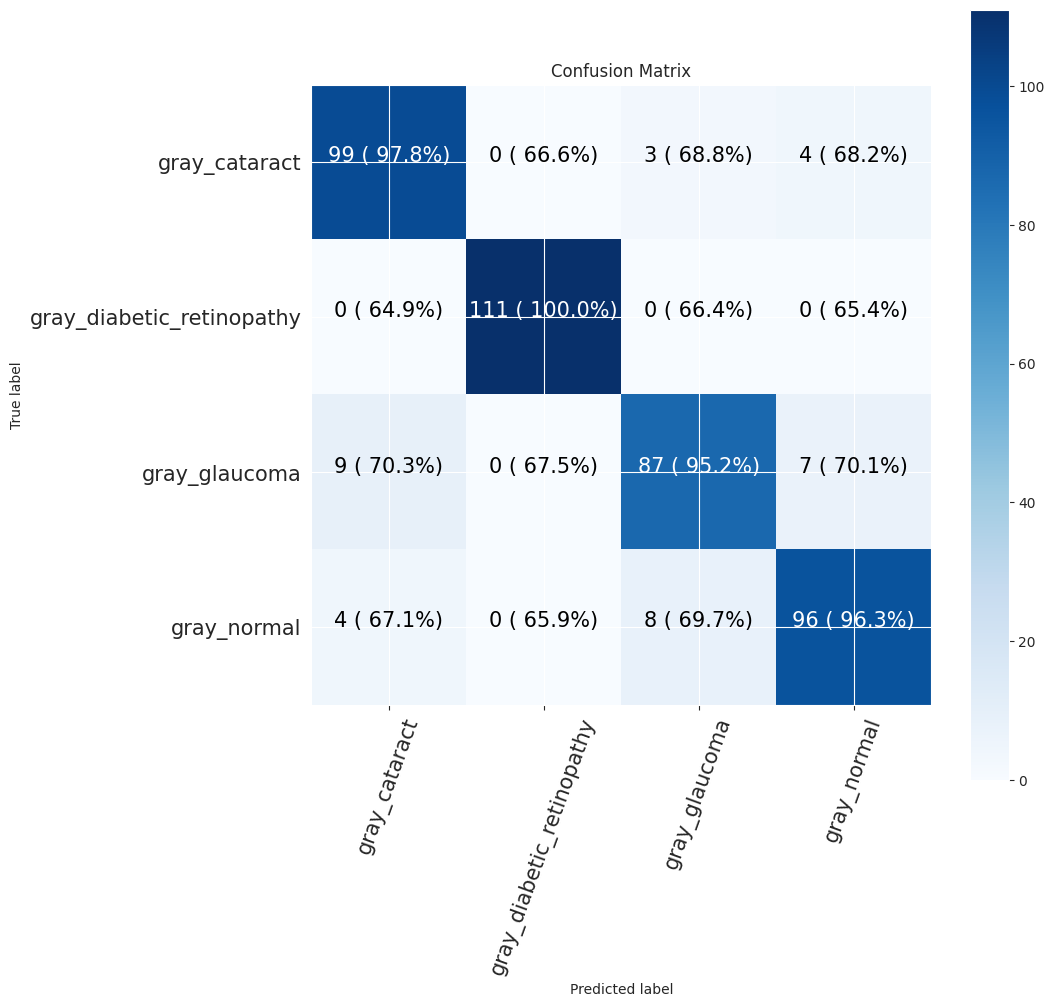

In [30]:
# Save Model
resnet50_model.save("resnet50_model.h5")

model = resnet50_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


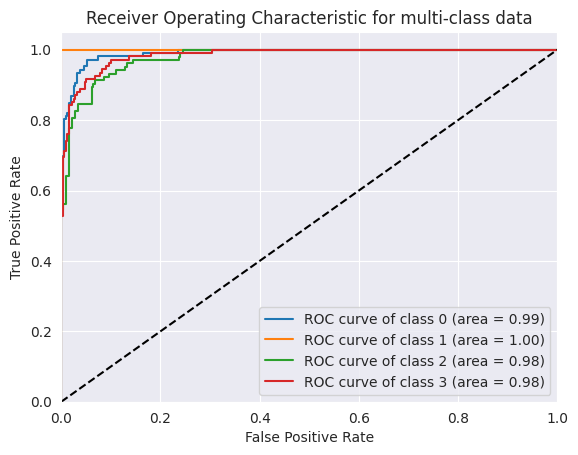

In [31]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet101**

In [32]:
from tensorflow.keras.applications import ResNet101

# Load ResNet-101 without the top classification layers (include_top=False)
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet101_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)

# Convert grayscale to 3 channels (matching the input requirement of ResNet-101)
conv_layer = layers.Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-101 model
x = resnet101_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-101 model for grayscale images
resnet101_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet101_model.summary()


171446536/171446536 [==============================] - 1s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 3)     30        
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_7 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_8 (Dense)             (None, 4)                 410

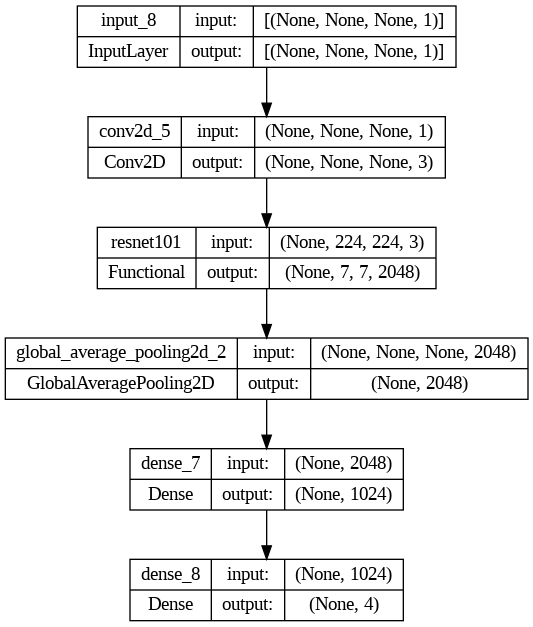

In [33]:
tf.keras.utils.plot_model(resnet101_model, show_shapes=True)

In [34]:
resnet101_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [35]:
resnet101_history= resnet101_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
212/212 [==============================] - 57s 235ms/step - loss: 0.7080 - accuracy: 0.7672 - val_loss: 0.6126 - val_accuracy: 0.7411 - lr: 0.0010
Epoch 2/20
212/212 [==============================] - 48s 224ms/step - loss: 0.4013 - accuracy: 0.8386 - val_loss: 0.3920 - val_accuracy: 0.8456 - lr: 0.0010
Epoch 3/20
212/212 [==============================] - 48s 225ms/step - loss: 0.3466 - accuracy: 0.8569 - val_loss: 0.4128 - val_accuracy: 0.8385 - lr: 0.0010
Epoch 4/20
212/212 [==============================] - 48s 224ms/step - loss: 0.3048 - accuracy: 0.8778 - val_loss: 0.3194 - val_accuracy: 0.8789 - lr: 0.0010
Epoch 5/20
212/212 [==============================] - 48s 225ms/step - loss: 0.2719 - accuracy: 0.8938 - val_loss: 0.3355 - val_accuracy: 0.8741 - lr: 0.0010
Epoch 6/20
212/212 [==============================] - 48s 224ms/step - loss: 0.2409 - accuracy: 0.9029 - val_loss: 0.3900 - val_accuracy: 0.8551 - lr: 0.0010
Epoch 7/20
212/212 [==============================] 

ResNet101 Evaluation

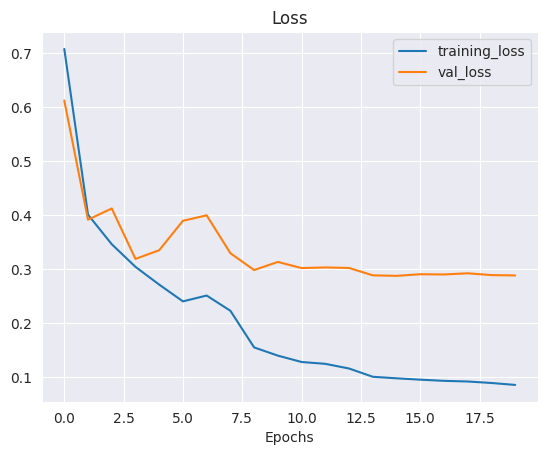

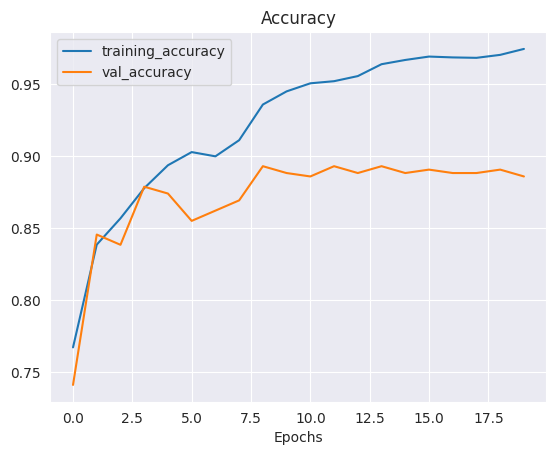

In [36]:
plot_loss_curves(resnet101_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 2s 83ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       106
           1       1.00      0.97      0.99       111
           2       0.81      0.82      0.81       103
           3       0.87      0.87      0.87       108

    accuracy                           0.89       428
   macro avg       0.89      0.89      0.89       428
weighted avg       0.89      0.89      0.89       428

Specificity: [0.2852852852852853, 0.3375, 0.2441860465116279, 0.281437125748503]
Mean Squared Error: : 0.11026763916015625
The average AUC-ROC is 0.982832853818508


[0.965625,
 0.66875,
 0.6975308641975309,
 0.678125,
 0.653125,
 0.990625,
 0.6635802469135802,
 0.65625,
 0.70625,
 0.678125,
 0.941358024691358,
 0.709375,
 0.675,
 0.6625,
 0.6975308641975309,
 0.95625]

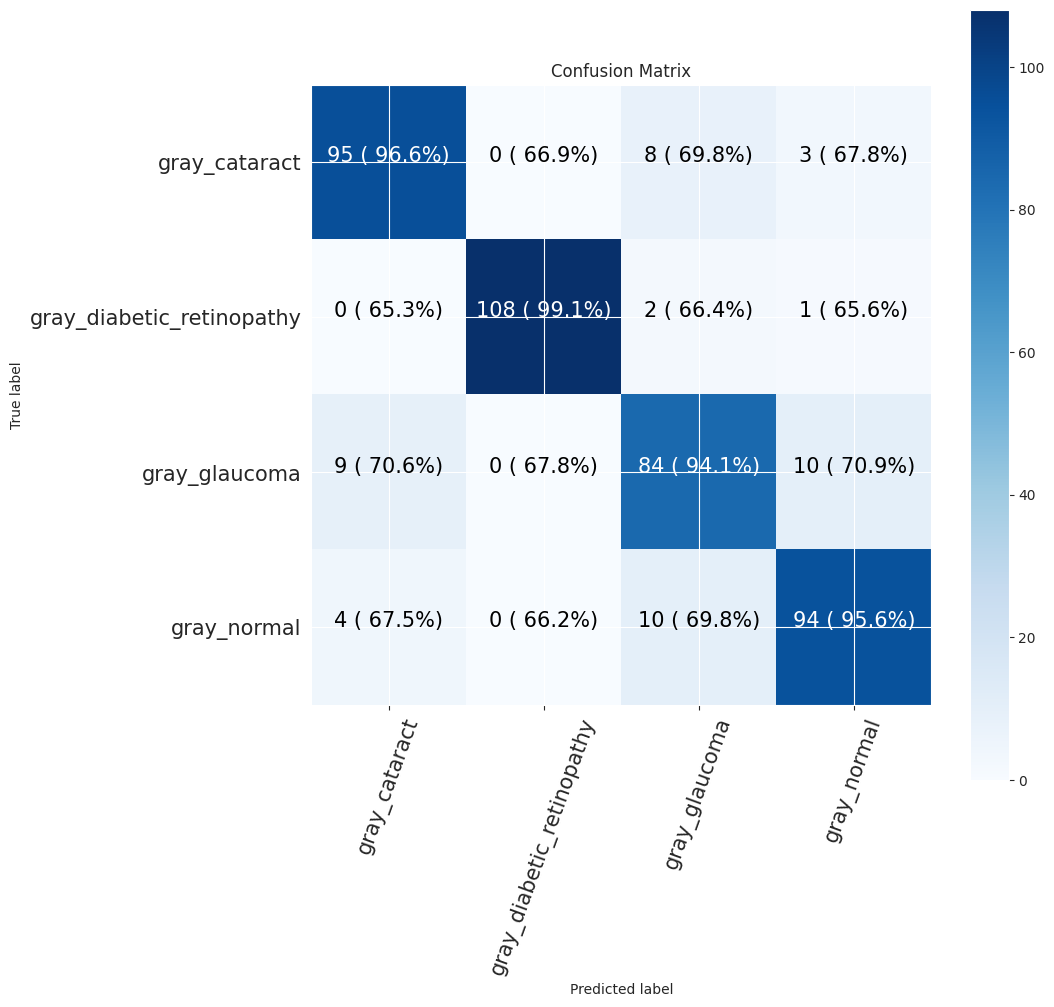

In [37]:
# Save Model
resnet101_model.save("resnet101_model.h5")

model = resnet101_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


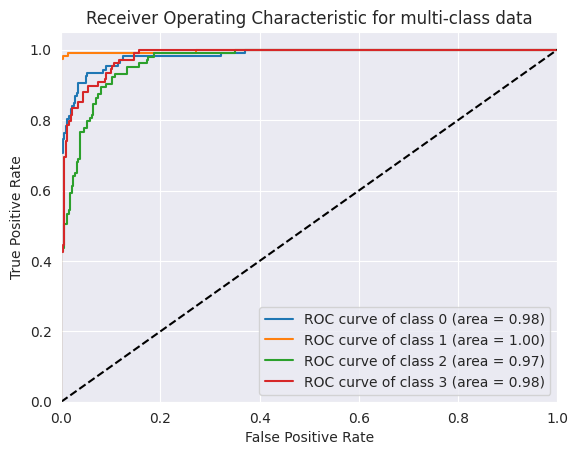

In [38]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **Batch size: 32**

In [39]:
epoch = 20
batchsize = 32

In [40]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir = "outputgrayscale/train"
test_dir =  "outputgrayscale/test"
val_dir = "outputgrayscale/val"

train_data = image_dataset_from_directory(train_dir, label_mode="categorical",
                                          image_size=(224, 224), batch_size=batchsize,
                                          shuffle=True, seed=42, color_mode='grayscale')

test_data = image_dataset_from_directory(test_dir, label_mode="categorical",
                                         image_size=(224, 224), batch_size=batchsize,
                                         shuffle=False, seed=42, color_mode='grayscale')

val_data = image_dataset_from_directory(val_dir, label_mode="categorical",
                                        image_size=(224, 224), batch_size=batchsize,
                                        shuffle=False, seed=42, color_mode='grayscale')


Found 3389 files belonging to 4 classes.
Found 428 files belonging to 4 classes.
Found 421 files belonging to 4 classes.


# **EfficientNetV2B3 Model**

In [41]:
efficient_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
efficient_model.trainable = False


In [42]:
inputs = layers.Input(shape=(224, 224, 1), name="input_layer")
x = data_aug(inputs)
# x = inputs
x = efficient_model(x)

# Apply Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dense(4)(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

efficient_model = tf.keras.Model(inputs, outputs)
efficient_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 1)]     0         
                                                                 
 data_augmentation_layer (S  (None, None, None, 1)     0         
 equential)                                                      
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d_3  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_9 (Dense)             (None, 32)                49184     
                                                           

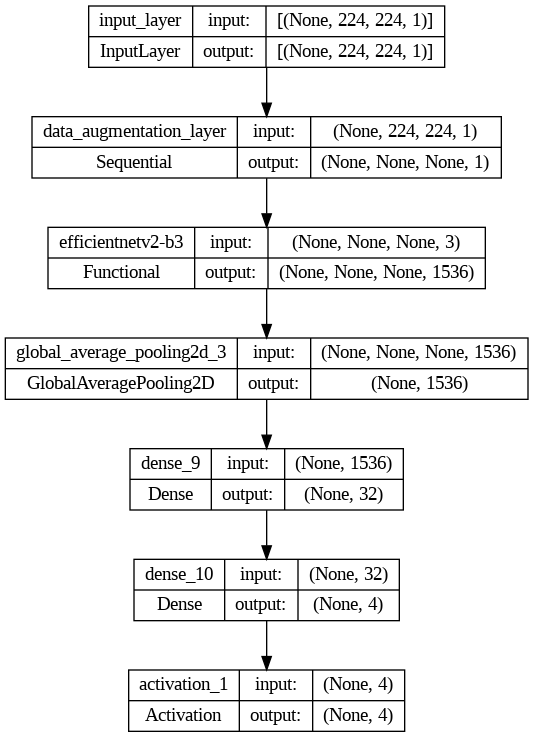

In [43]:
tf.keras.utils.plot_model(efficient_model, show_shapes=True)

In [44]:
efficient_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [45]:
efficient_history = efficient_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
106/106 [==============================] - 64s 492ms/step - loss: 0.7131 - accuracy: 0.7035 - val_loss: 0.7641 - val_accuracy: 0.6722 - lr: 0.0010
Epoch 2/20
106/106 [==============================] - 46s 434ms/step - loss: 0.5741 - accuracy: 0.7740 - val_loss: 0.7435 - val_accuracy: 0.7055 - lr: 0.0010
Epoch 3/20
106/106 [==============================] - 41s 384ms/step - loss: 0.5217 - accuracy: 0.7923 - val_loss: 0.6658 - val_accuracy: 0.7292 - lr: 0.0010
Epoch 4/20
106/106 [==============================] - 38s 355ms/step - loss: 0.4907 - accuracy: 0.8053 - val_loss: 0.6588 - val_accuracy: 0.7340 - lr: 0.0010
Epoch 5/20
106/106 [==============================] - 36s 342ms/step - loss: 0.4822 - accuracy: 0.8165 - val_loss: 0.6753 - val_accuracy: 0.7553 - lr: 0.0010
Epoch 6/20
106/106 [==============================] - 35s 330ms/step - loss: 0.4442 - accuracy: 0.8247 - val_loss: 0.6130 - val_accuracy: 0.7553 - lr: 0.0010
Epoch 7/20
106/106 [==============================] 

EfficientNetV2B3 Evaluation

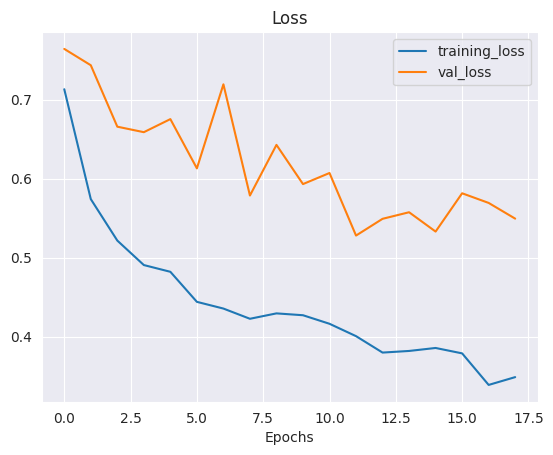

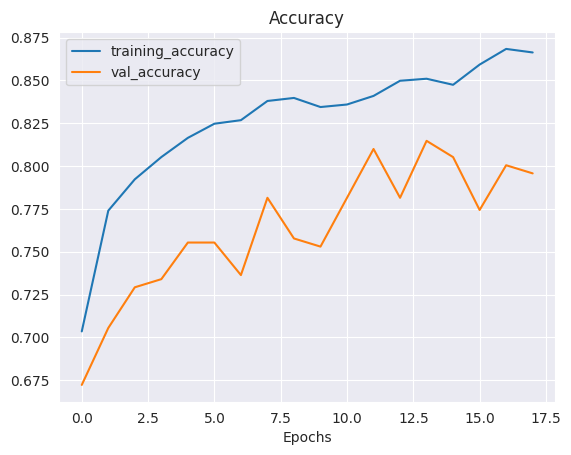

In [46]:
plot_loss_curves(efficient_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 1s 77ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       106
           1       0.85      0.95      0.89       111
           2       0.94      0.56      0.70       103
           3       0.73      0.86      0.79       108

    accuracy                           0.83       428
   macro avg       0.84      0.83      0.82       428
weighted avg       0.84      0.83      0.82       428

Specificity: [0.3009118541033435, 0.32507739938080493, 0.15675675675675677, 0.27761194029850744]
Mean Squared Error: : 0.1245446503162384
The average AUC-ROC is 0.9638513893818432


[0.9777070063694268,
 0.6513157894736842,
 0.7158469945355191,
 0.6633333333333333,
 0.6496815286624203,
 0.9802631578947368,
 0.6994535519125683,
 0.6433333333333333,
 0.7133757961783439,
 0.680921052631579,
 0.8770491803278688,
 0.7433333333333333,
 0.6592356687898089,
 0.6875,
 0.7076502732240437,
 0.95]

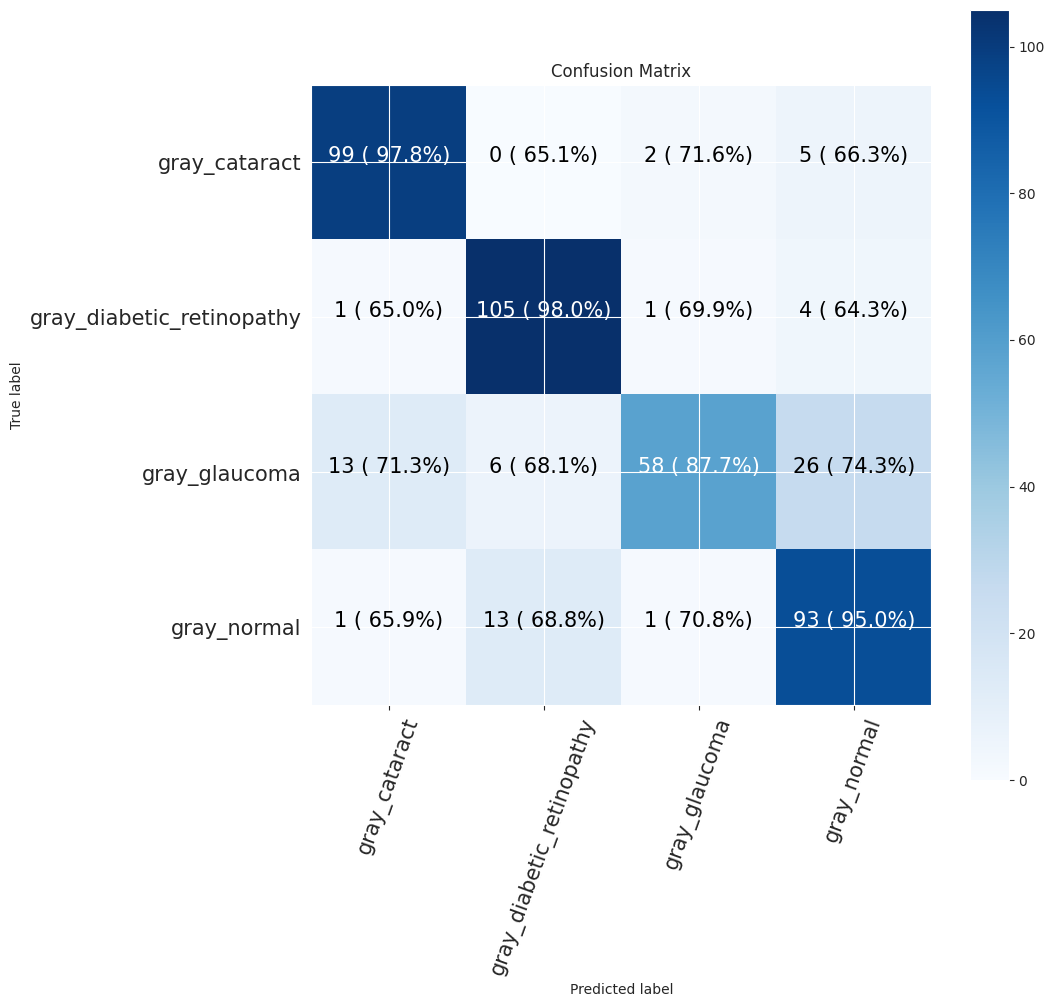

In [47]:
# Save Model
efficient_model.save("efficient_model.h5")

model = efficient_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


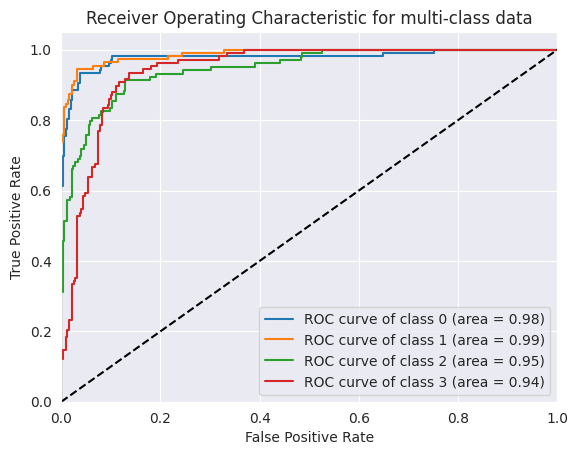

In [48]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **CNN model**

In [49]:
from tensorflow.keras.models import Sequential

# Create a Sequential model
cnn_model = Sequential()

# Add convolutional layers for feature extraction
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))  # Grayscale image has 1 channel

# Freeze the layers in the base model
for layer in cnn_model.layers:
    layer.trainable = False

grayscale_input = layers.Input(shape=(224, 224, 1))

grayscale_input = data_aug(grayscale_input)

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for dense layers
cnn_model.add(layers.Flatten())

# Add dense layers for classification
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dense(4, activation='softmax'))  # Set num_classes to your specific number of classes

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 26, 26, 128)      

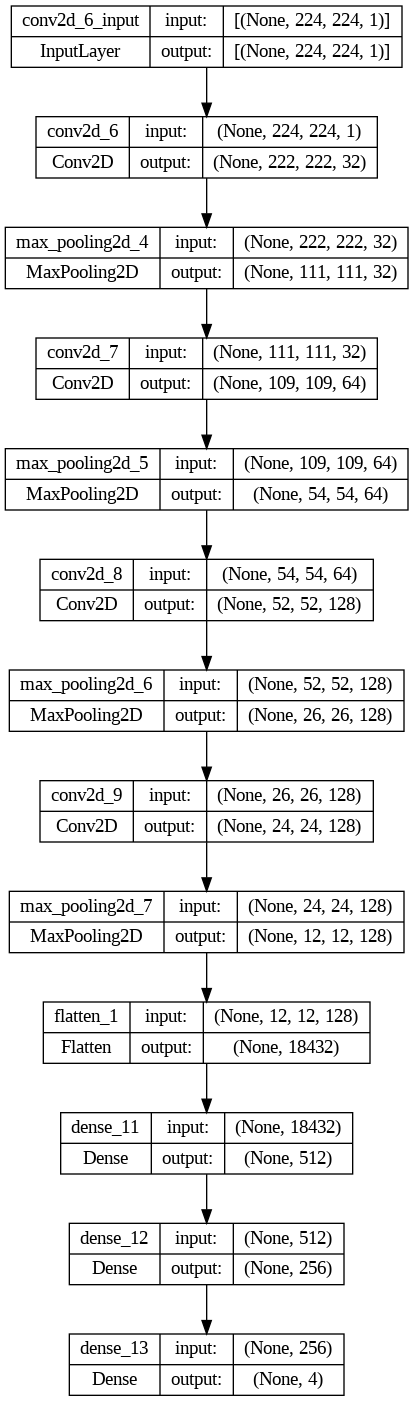

In [50]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [51]:
cnn_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [52]:
cnn_history = cnn_model.fit(train_data,epochs = epoch, validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
106/106 [==============================] - 7s 42ms/step - loss: 3.3244 - accuracy: 0.5382 - val_loss: 0.7782 - val_accuracy: 0.6508 - lr: 0.0010
Epoch 2/20
106/106 [==============================] - 4s 35ms/step - loss: 0.7268 - accuracy: 0.6574 - val_loss: 0.7925 - val_accuracy: 0.6936 - lr: 0.0010
Epoch 3/20
106/106 [==============================] - 4s 36ms/step - loss: 0.6460 - accuracy: 0.7040 - val_loss: 0.6724 - val_accuracy: 0.7245 - lr: 0.0010
Epoch 4/20
106/106 [==============================] - 4s 36ms/step - loss: 0.6188 - accuracy: 0.7138 - val_loss: 0.6747 - val_accuracy: 0.7007 - lr: 0.0010
Epoch 5/20
106/106 [==============================] - 4s 36ms/step - loss: 0.6168 - accuracy: 0.7117 - val_loss: 0.7259 - val_accuracy: 0.6936 - lr: 0.0010
Epoch 6/20
106/106 [==============================] - 4s 36ms/step - loss: 0.6272 - accuracy: 0.7150 - val_loss: 0.8600 - val_accuracy: 0.6817 - lr: 0.0010
Epoch 7/20
106/106 [==============================] - 4s 35ms/st

CNN Evaluation

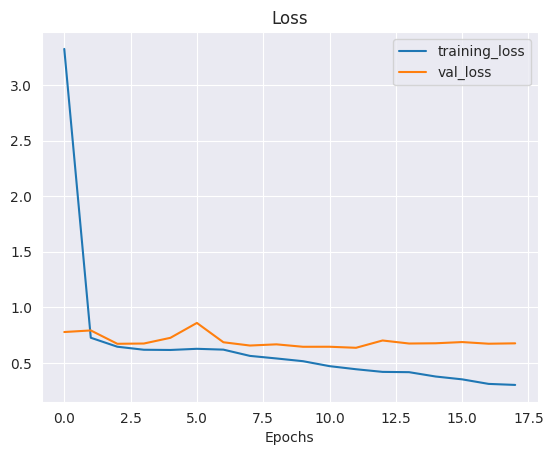

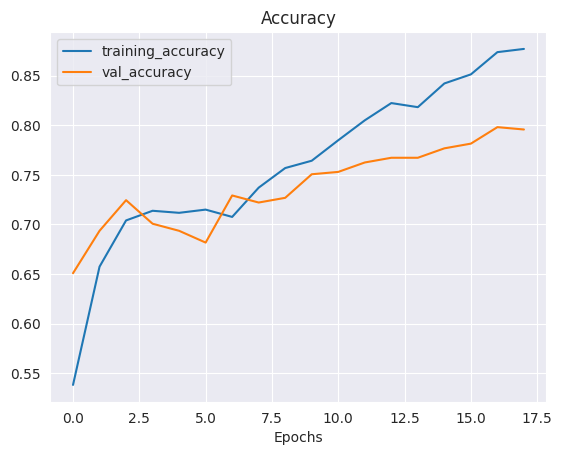

In [53]:
plot_loss_curves(cnn_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 0s 13ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.74      0.75       106
           1       0.98      0.99      0.99       111
           2       0.77      0.64      0.70       103
           3       0.76      0.90      0.83       108

    accuracy                           0.82       428
   macro avg       0.82      0.82      0.81       428
weighted avg       0.82      0.82      0.82       428

Specificity: [0.22285714285714286, 0.34591194968553457, 0.18232044198895028, 0.2930513595166163]
Mean Squared Error: : 0.12431858479976654
The average AUC-ROC is 0.9459519357964781


[0.9138461538461539,
 0.6645569620253164,
 0.7309941520467836,
 0.6943521594684385,
 0.6584615384615384,
 0.9968354430379747,
 0.6783625730994152,
 0.6312292358803987,
 0.7415384615384616,
 0.680379746835443,
 0.8918128654970761,
 0.7109634551495017,
 0.6861538461538461,
 0.6582278481012658,
 0.6988304093567251,
 0.9634551495016611]

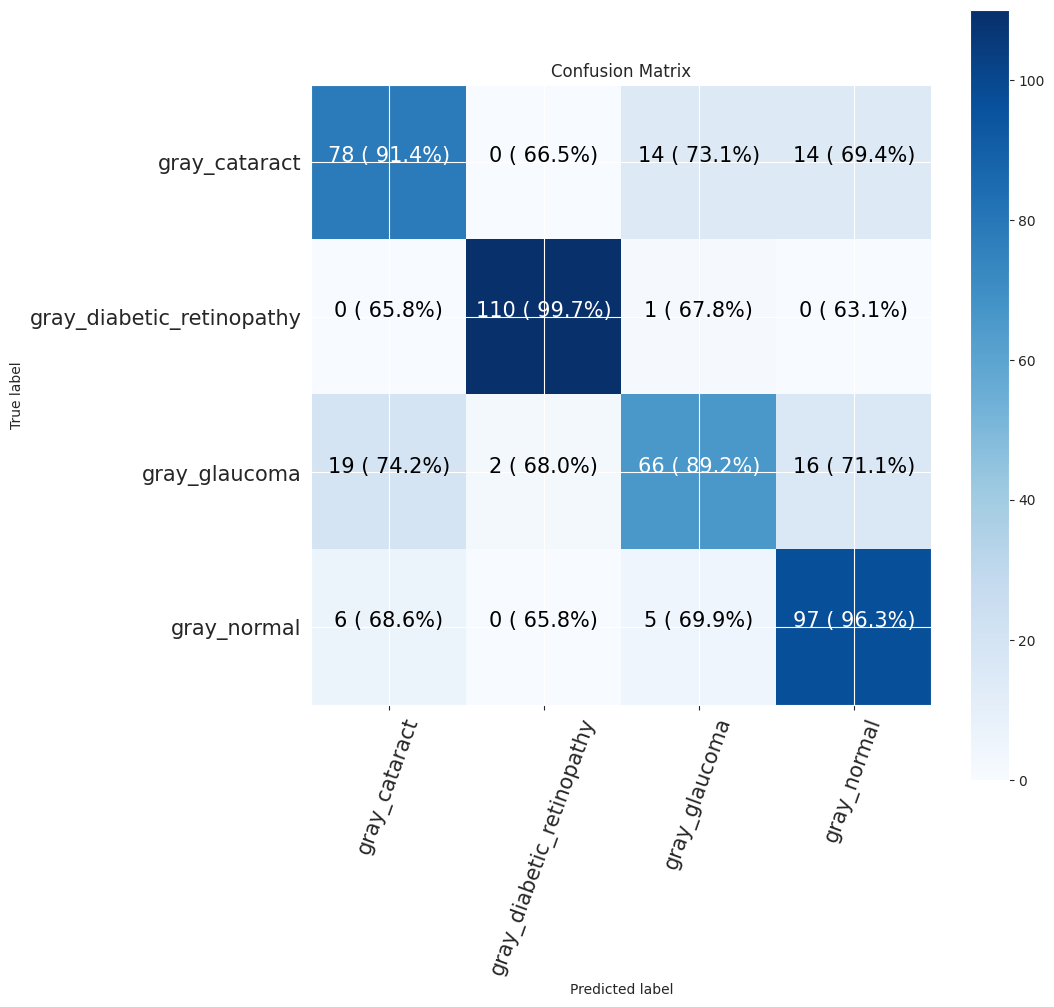

In [54]:
# Save Model
cnn_model.save("cnn_model.h5")

model = cnn_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


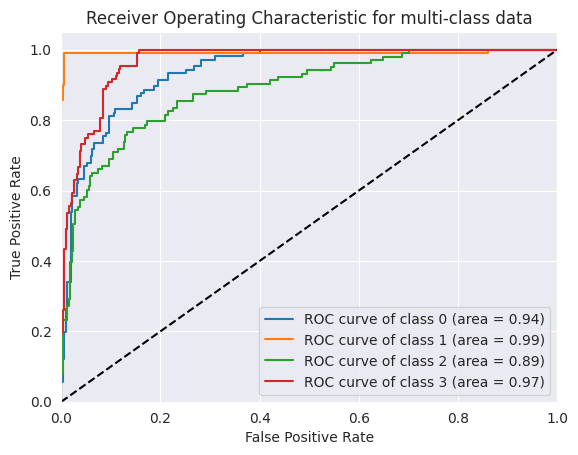

In [55]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet50 Model**



In [56]:
from tensorflow.keras.applications import ResNet50

# Load ResNet-50 without the top classification layers (include_top=False)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet50_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)
# Convert grayscale to 3 channels (matching the input requirement of ResNet-50)
conv_layer = Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-50 model
x = resnet50_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-50 model for grayscale images
resnet50_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet50_model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_10 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_14 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_15 (Dense)            (None, 4)                 4100      
                                                           

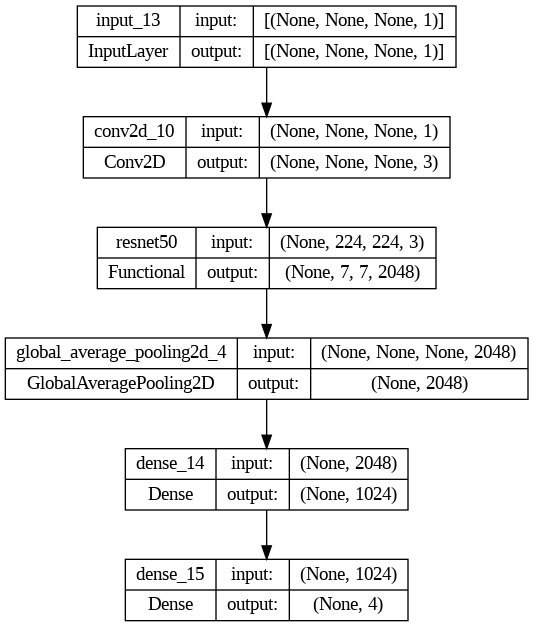

In [57]:
tf.keras.utils.plot_model(resnet50_model, show_shapes=True)

In [58]:
resnet50_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [59]:
resnet50_history = resnet50_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
106/106 [==============================] - 36s 290ms/step - loss: 0.6423 - accuracy: 0.7760 - val_loss: 0.3924 - val_accuracy: 0.8456 - lr: 0.0010
Epoch 2/20
106/106 [==============================] - 28s 263ms/step - loss: 0.3656 - accuracy: 0.8587 - val_loss: 0.3249 - val_accuracy: 0.8765 - lr: 0.0010
Epoch 3/20
106/106 [==============================] - 28s 261ms/step - loss: 0.2869 - accuracy: 0.8891 - val_loss: 0.3216 - val_accuracy: 0.8717 - lr: 0.0010
Epoch 4/20
106/106 [==============================] - 28s 262ms/step - loss: 0.2628 - accuracy: 0.9006 - val_loss: 0.3384 - val_accuracy: 0.8717 - lr: 0.0010
Epoch 5/20
106/106 [==============================] - 28s 263ms/step - loss: 0.2344 - accuracy: 0.9071 - val_loss: 0.3033 - val_accuracy: 0.8931 - lr: 0.0010
Epoch 6/20
106/106 [==============================] - 28s 262ms/step - loss: 0.2168 - accuracy: 0.9206 - val_loss: 0.2964 - val_accuracy: 0.8860 - lr: 0.0010
Epoch 7/20
106/106 [==============================] 

ResNet50 Evaluation

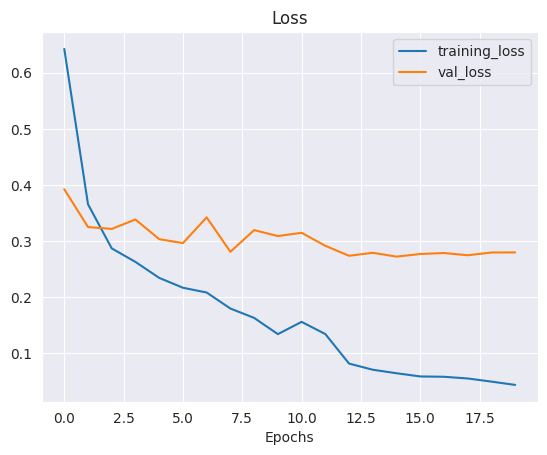

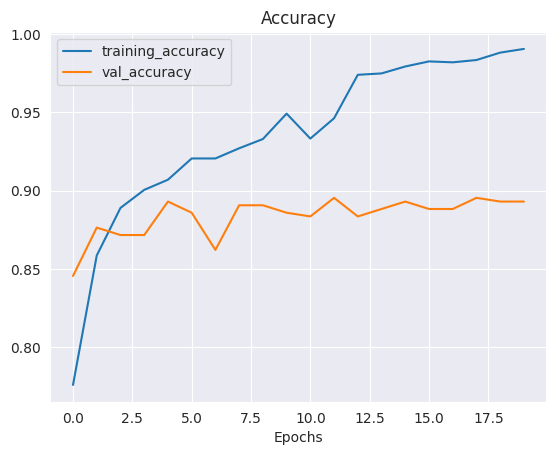

In [60]:
plot_loss_curves(resnet50_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 1s 94ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       106
           1       0.99      1.00      1.00       111
           2       0.85      0.87      0.86       103
           3       0.91      0.85      0.88       108

    accuracy                           0.91       428
   macro avg       0.91      0.91      0.91       428
weighted avg       0.91      0.91      0.91       428

Specificity: [0.296969696969697, 0.3501577287066246, 0.26627218934911245, 0.27380952380952384]
Mean Squared Error: : 0.1067153662443161
The average AUC-ROC is 0.9876961351975373


[0.9749216300940439,
 0.6645569620253164,
 0.6832298136645962,
 0.6880733944954128,
 0.6520376175548589,
 1.0,
 0.65527950310559,
 0.6605504587155964,
 0.6990595611285266,
 0.6772151898734177,
 0.9596273291925466,
 0.7003058103975535,
 0.6739811912225705,
 0.6582278481012658,
 0.7018633540372671,
 0.9510703363914373]

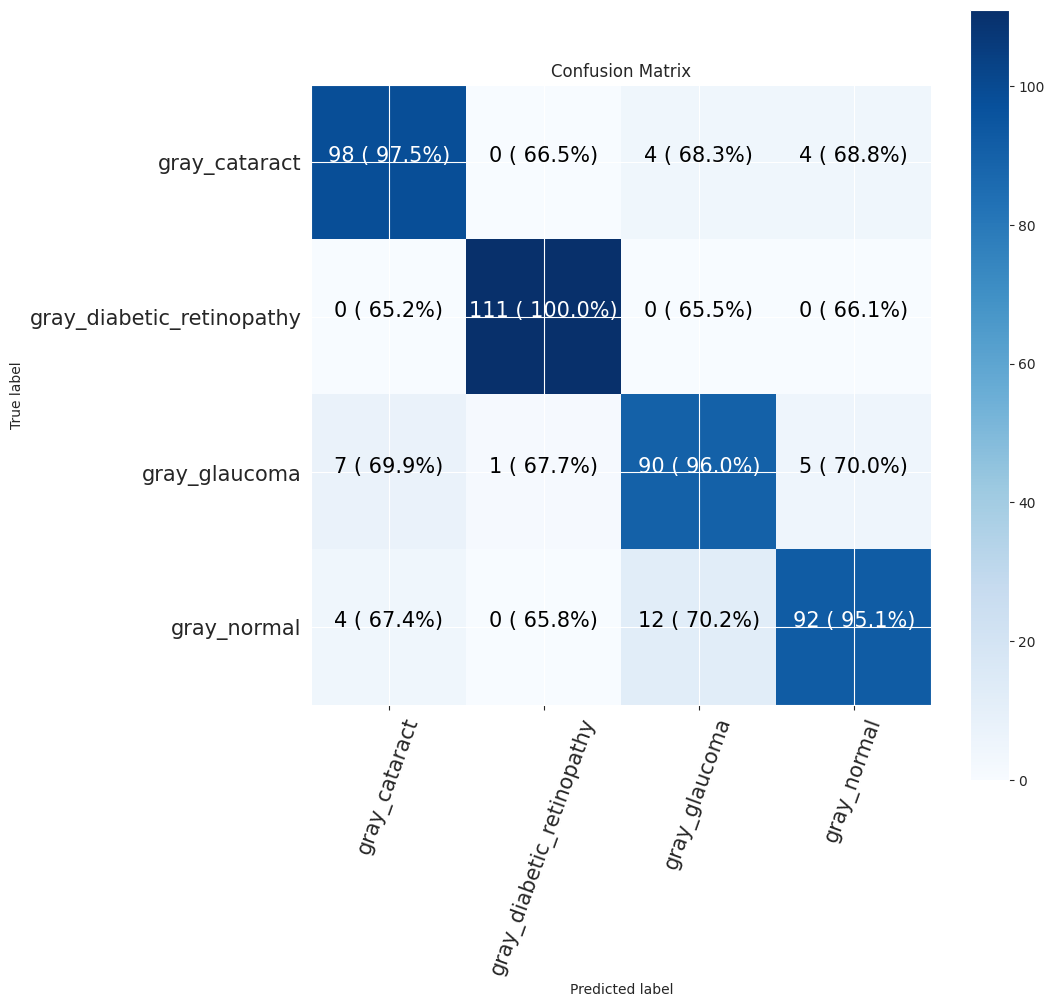

In [61]:
# Save Model
resnet50_model.save("resnet50_model.h5")

model = resnet50_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


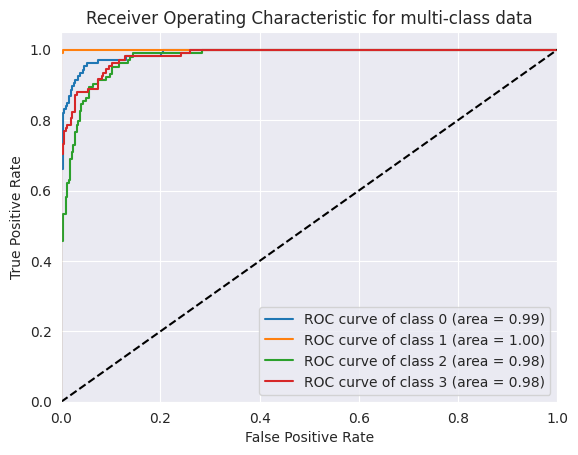

In [62]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet101**

In [63]:
from tensorflow.keras.applications import ResNet101

# Load ResNet-101 without the top classification layers (include_top=False)
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet101_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)

# Convert grayscale to 3 channels (matching the input requirement of ResNet-101)
conv_layer = layers.Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-101 model
x = resnet101_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-101 model for grayscale images
resnet101_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet101_model.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_11 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_5  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_16 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_17 (Dense)            (None, 4)                 4100      
                                                           

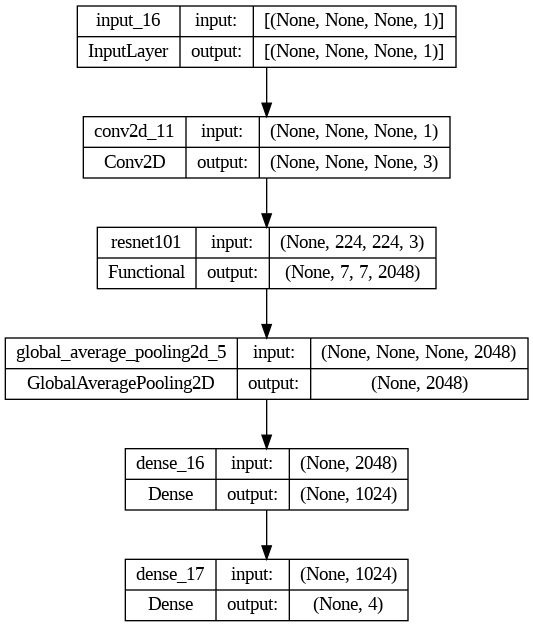

In [64]:
tf.keras.utils.plot_model(resnet101_model, show_shapes=True)

In [65]:
resnet101_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [66]:
resnet101_history= resnet101_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
106/106 [==============================] - 54s 451ms/step - loss: 0.7419 - accuracy: 0.7566 - val_loss: 0.4798 - val_accuracy: 0.8219 - lr: 0.0010
Epoch 2/20
106/106 [==============================] - 46s 429ms/step - loss: 0.4031 - accuracy: 0.8466 - val_loss: 0.3909 - val_accuracy: 0.8504 - lr: 0.0010
Epoch 3/20
106/106 [==============================] - 46s 431ms/step - loss: 0.3189 - accuracy: 0.8793 - val_loss: 0.3975 - val_accuracy: 0.8337 - lr: 0.0010
Epoch 4/20
106/106 [==============================] - 46s 430ms/step - loss: 0.2913 - accuracy: 0.8832 - val_loss: 0.3666 - val_accuracy: 0.8504 - lr: 0.0010
Epoch 5/20
106/106 [==============================] - 46s 431ms/step - loss: 0.2622 - accuracy: 0.8988 - val_loss: 0.3866 - val_accuracy: 0.8432 - lr: 0.0010
Epoch 6/20
106/106 [==============================] - 46s 431ms/step - loss: 0.2202 - accuracy: 0.9212 - val_loss: 0.2999 - val_accuracy: 0.8884 - lr: 0.0010
Epoch 7/20
106/106 [==============================] 

ResNet101 Evaluation

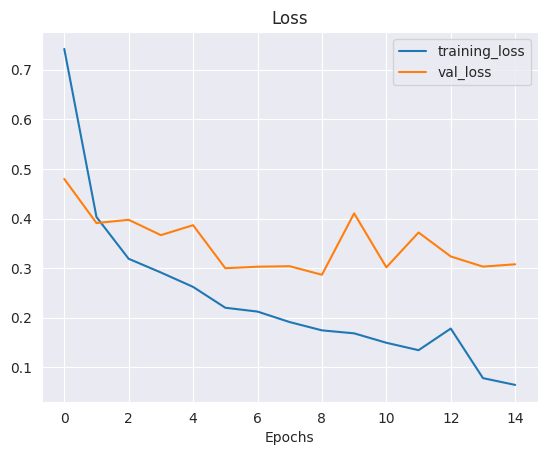

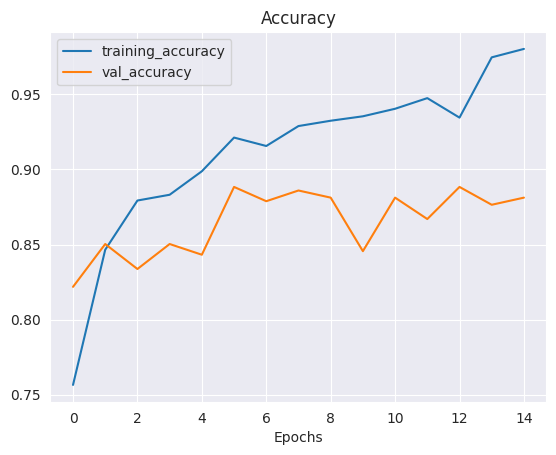

In [67]:
plot_loss_curves(resnet101_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 2s 160ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       106
           1       1.00      0.98      0.99       111
           2       0.78      0.84      0.81       103
           3       0.87      0.82      0.85       108

    accuracy                           0.89       428
   macro avg       0.89      0.89      0.89       428
weighted avg       0.90      0.89      0.89       428

Specificity: [0.2930513595166163, 0.34169278996865204, 0.25513196480938416, 0.26253687315634217]
Mean Squared Error: : 0.10813271254301071
The average AUC-ROC is 0.9852387540676141


[0.9721362229102167,
 0.6677115987460815,
 0.6867088607594937,
 0.6809815950920245,
 0.6563467492260062,
 0.9937304075235109,
 0.6518987341772152,
 0.6625766871165644,
 0.6996904024767802,
 0.677115987460815,
 0.9493670886075949,
 0.7147239263803681,
 0.6718266253869969,
 0.6614420062695925,
 0.7120253164556962,
 0.941717791411043]

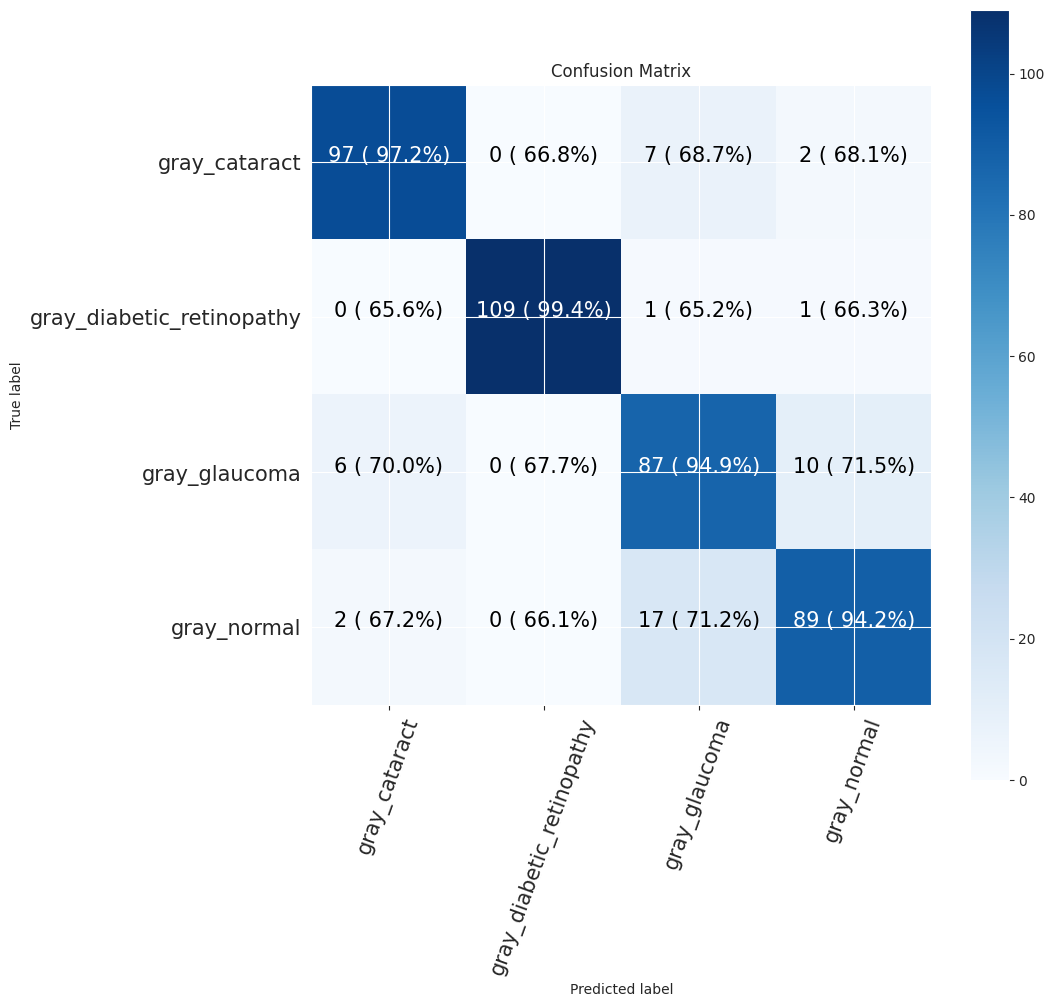

In [68]:
# Save Model
resnet101_model.save("resnet101_model.h5")

model = resnet101_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


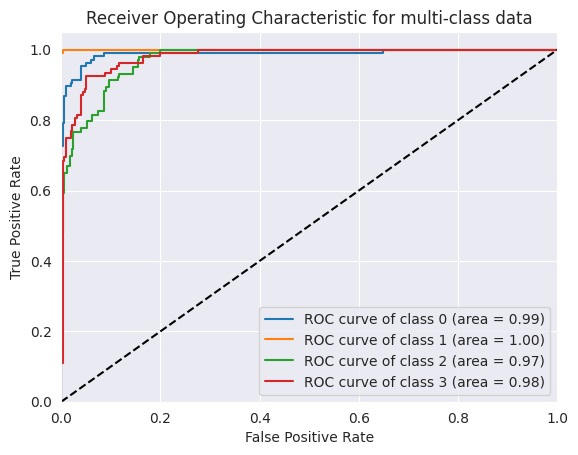

In [69]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **Batch size: 64**

In [70]:
epoch = 20
batchsize = 64

In [71]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir = "outputgrayscale/train"
test_dir =  "outputgrayscale/test"
val_dir = "outputgrayscale/val"

train_data = image_dataset_from_directory(train_dir, label_mode="categorical",
                                          image_size=(224, 224), batch_size=batchsize,
                                          shuffle=True, seed=42, color_mode='grayscale')

test_data = image_dataset_from_directory(test_dir, label_mode="categorical",
                                         image_size=(224, 224), batch_size=batchsize,
                                         shuffle=False, seed=42, color_mode='grayscale')

val_data = image_dataset_from_directory(val_dir, label_mode="categorical",
                                        image_size=(224, 224), batch_size=batchsize,
                                        shuffle=False, seed=42, color_mode='grayscale')


Found 3389 files belonging to 4 classes.
Found 428 files belonging to 4 classes.
Found 421 files belonging to 4 classes.


# **EfficientNetV2B3 Model**

In [72]:
efficient_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
efficient_model.trainable = False


In [73]:
inputs = layers.Input(shape=(224, 224, 1), name="input_layer")
x = data_aug(inputs)
# x = inputs
x = efficient_model(x)

# Apply Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dense(4)(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

efficient_model = tf.keras.Model(inputs, outputs)
efficient_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 1)]     0         
                                                                 
 data_augmentation_layer (S  (None, None, None, 1)     0         
 equential)                                                      
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d_6  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_18 (Dense)            (None, 32)                49184     
                                                           

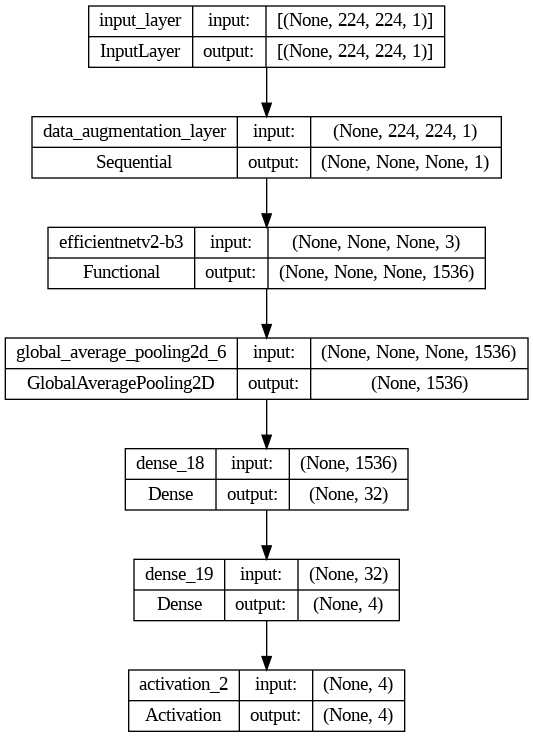

In [74]:
tf.keras.utils.plot_model(efficient_model, show_shapes=True)

In [75]:
efficient_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [76]:
efficient_history = efficient_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
53/53 [==============================] - 66s 1s/step - loss: 0.8443 - accuracy: 0.6512 - val_loss: 0.7775 - val_accuracy: 0.6461 - lr: 0.0010
Epoch 2/20
53/53 [==============================] - 44s 829ms/step - loss: 0.6120 - accuracy: 0.7533 - val_loss: 0.6967 - val_accuracy: 0.7102 - lr: 0.0010
Epoch 3/20
53/53 [==============================] - 44s 825ms/step - loss: 0.5658 - accuracy: 0.7740 - val_loss: 0.7113 - val_accuracy: 0.7007 - lr: 0.0010
Epoch 4/20
53/53 [==============================] - 38s 703ms/step - loss: 0.5239 - accuracy: 0.7991 - val_loss: 0.7340 - val_accuracy: 0.7007 - lr: 0.0010
Epoch 5/20
53/53 [==============================] - 37s 685ms/step - loss: 0.5035 - accuracy: 0.8055 - val_loss: 0.6320 - val_accuracy: 0.7530 - lr: 0.0010
Epoch 6/20
53/53 [==============================] - 36s 681ms/step - loss: 0.4857 - accuracy: 0.8129 - val_loss: 0.6145 - val_accuracy: 0.7292 - lr: 0.0010
Epoch 7/20
53/53 [==============================] - 36s 675ms/step 

EfficientNetV2B3 Evaluation

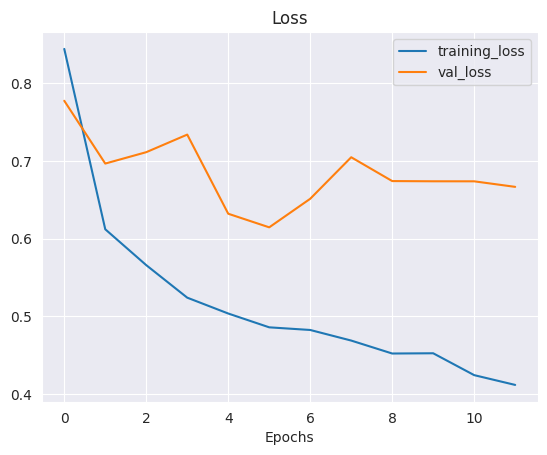

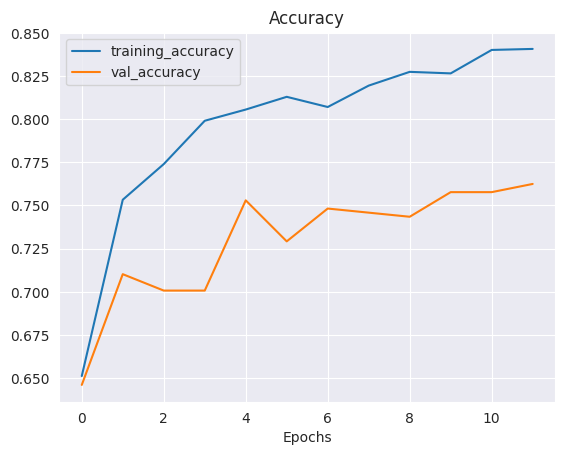

In [77]:
plot_loss_curves(efficient_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 1s 148ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       106
           1       0.81      0.91      0.86       111
           2       0.94      0.45      0.61       103
           3       0.63      0.83      0.72       108

    accuracy                           0.78       428
   macro avg       0.81      0.77      0.76       428
weighted avg       0.81      0.78      0.77       428

Specificity: [0.2852852852852853, 0.308868501529052, 0.12041884816753927, 0.26627218934911245]
Mean Squared Error: : 0.1304916888475418
The average AUC-ROC is 0.9490065199663683


[0.9651898734177216,
 0.6513157894736842,
 0.7229551451187335,
 0.6631578947368421,
 0.6518987341772152,
 0.9671052631578947,
 0.7097625329815304,
 0.6385964912280702,
 0.7215189873417721,
 0.6842105263157895,
 0.8496042216358839,
 0.7614035087719299,
 0.6613924050632911,
 0.6973684210526315,
 0.7176781002638523,
 0.9368421052631579]

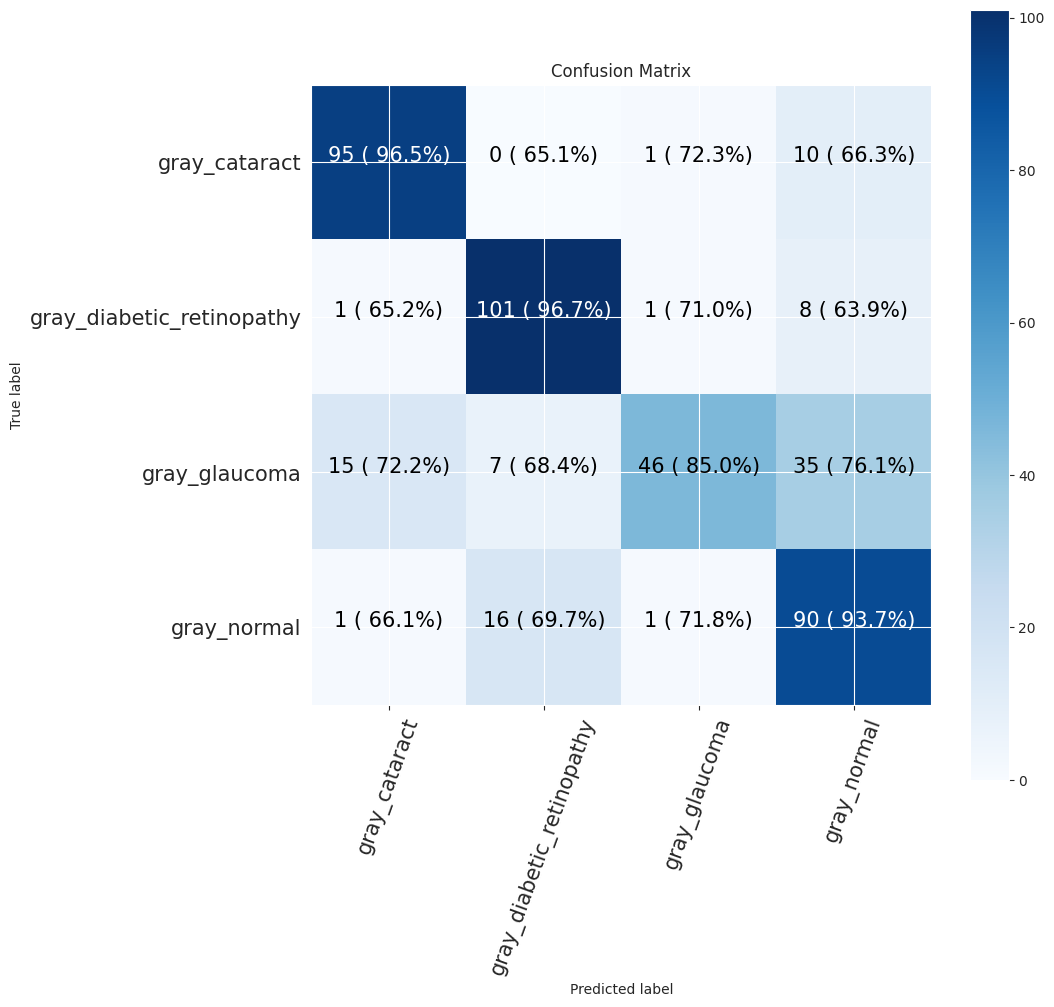

In [78]:
# Save Model
efficient_model.save("efficient_model.h5")

model = efficient_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


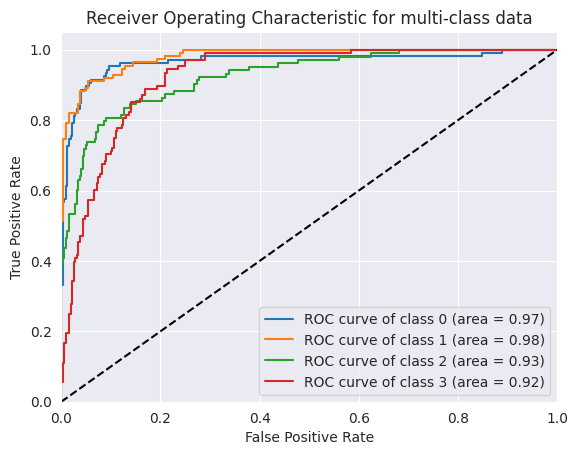

In [79]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **CNN model**

In [80]:
from tensorflow.keras.models import Sequential

# Create a Sequential model
cnn_model = Sequential()

# Add convolutional layers for feature extraction
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))  # Grayscale image has 1 channel

# Freeze the layers in the base model
for layer in cnn_model.layers:
    layer.trainable = False

grayscale_input = layers.Input(shape=(224, 224, 1))

grayscale_input = data_aug(grayscale_input)

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for dense layers
cnn_model.add(layers.Flatten())

# Add dense layers for classification
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dense(4, activation='softmax'))  # Set num_classes to your specific number of classes

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 26, 26, 128)      

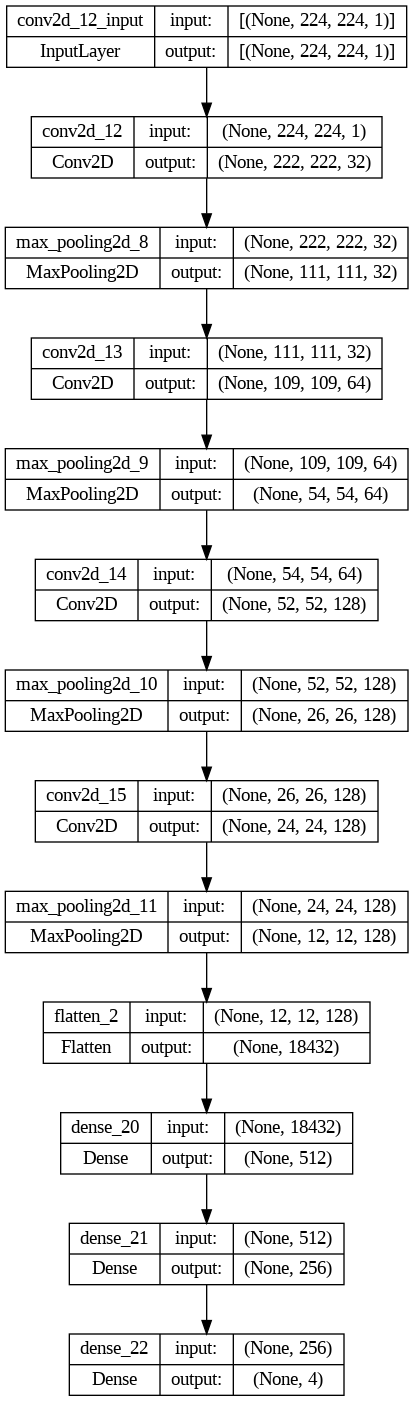

In [81]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [82]:
cnn_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [83]:
cnn_history = cnn_model.fit(train_data,epochs = epoch, validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
53/53 [==============================] - 8s 94ms/step - loss: 5.4517 - accuracy: 0.4919 - val_loss: 0.8904 - val_accuracy: 0.6271 - lr: 0.0010
Epoch 2/20
53/53 [==============================] - 4s 65ms/step - loss: 0.7036 - accuracy: 0.6866 - val_loss: 0.6759 - val_accuracy: 0.6865 - lr: 0.0010
Epoch 3/20
53/53 [==============================] - 4s 65ms/step - loss: 0.5775 - accuracy: 0.7530 - val_loss: 0.5498 - val_accuracy: 0.7672 - lr: 0.0010
Epoch 4/20
53/53 [==============================] - 4s 65ms/step - loss: 0.4953 - accuracy: 0.7873 - val_loss: 0.4831 - val_accuracy: 0.8242 - lr: 0.0010
Epoch 5/20
53/53 [==============================] - 4s 65ms/step - loss: 0.4650 - accuracy: 0.8182 - val_loss: 1.6502 - val_accuracy: 0.4418 - lr: 0.0010
Epoch 6/20
53/53 [==============================] - 4s 65ms/step - loss: 0.5148 - accuracy: 0.7864 - val_loss: 0.5247 - val_accuracy: 0.7886 - lr: 0.0010
Epoch 7/20
53/53 [==============================] - 4s 65ms/step - loss: 0.4

CNN Evaluation

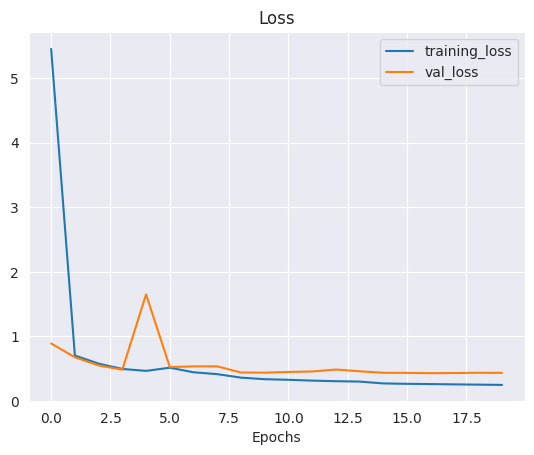

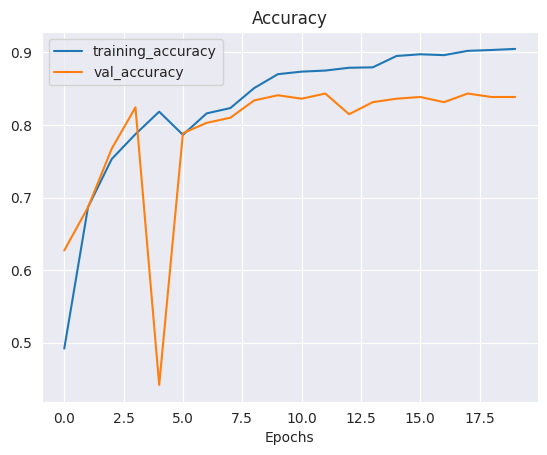

In [84]:
plot_loss_curves(cnn_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 0s 22ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.85      0.81       106
           1       0.99      1.00      1.00       111
           2       0.86      0.66      0.75       103
           3       0.80      0.90      0.85       108

    accuracy                           0.86       428
   macro avg       0.86      0.85      0.85       428
weighted avg       0.86      0.86      0.85       428

Specificity: [0.26627218934911245, 0.3501577287066246, 0.18888888888888888, 0.2930513595166163]
Mean Squared Error: : 0.1193663477897644
The average AUC-ROC is 0.9629196701257452


[0.9487179487179487,
 0.6677215189873418,
 0.7163323782234957,
 0.6807817589576547,
 0.6442307692307693,
 1.0,
 0.6819484240687679,
 0.6384364820846905,
 0.7307692307692307,
 0.6740506329113924,
 0.8997134670487106,
 0.7166123778501629,
 0.6762820512820513,
 0.6582278481012658,
 0.7020057306590258,
 0.9641693811074918]

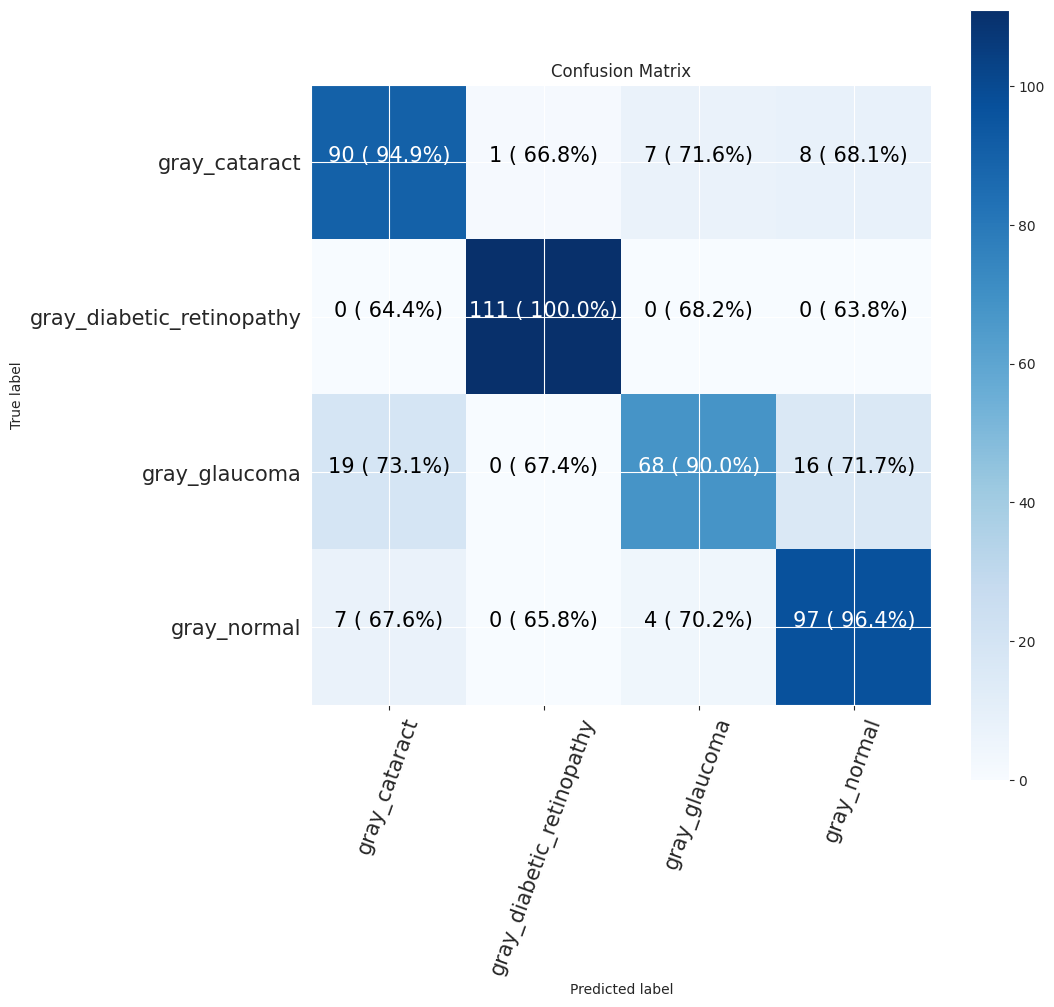

In [85]:
# Save Model
cnn_model.save("cnn_model.h5")

model = cnn_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


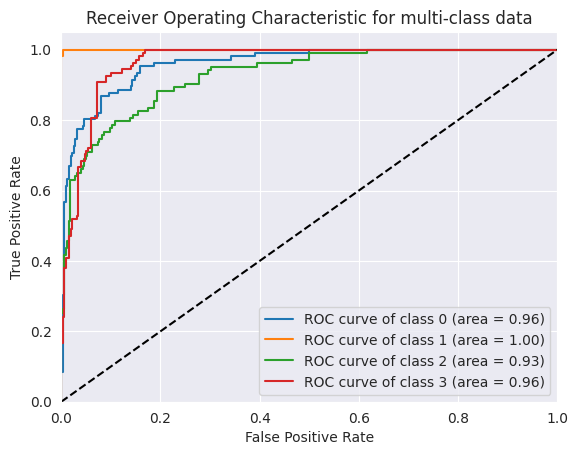

In [86]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet50 Model**



In [87]:
from tensorflow.keras.applications import ResNet50

# Load ResNet-50 without the top classification layers (include_top=False)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet50_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)
# Convert grayscale to 3 channels (matching the input requirement of ResNet-50)
conv_layer = Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-50 model
x = resnet50_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-50 model for grayscale images
resnet50_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet50_model.summary()


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_16 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_7  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_23 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_24 (Dense)            (None, 4)                 4100      
                                                           

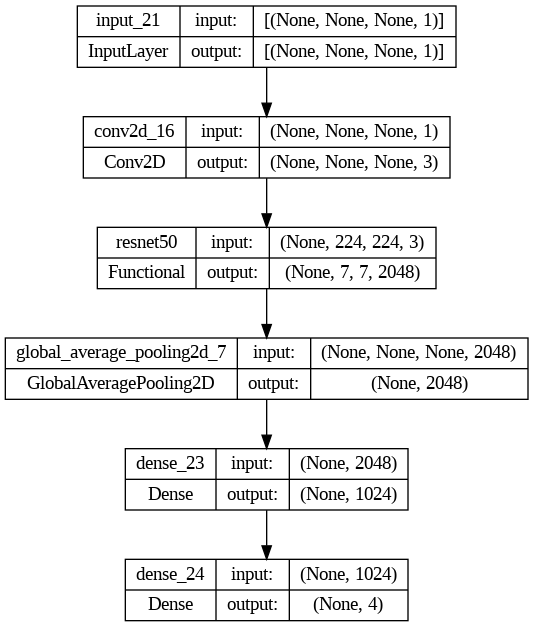

In [88]:
tf.keras.utils.plot_model(resnet50_model, show_shapes=True)

In [89]:
resnet50_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [90]:
resnet50_history = resnet50_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
53/53 [==============================] - 40s 610ms/step - loss: 0.7577 - accuracy: 0.7362 - val_loss: 0.4622 - val_accuracy: 0.8195 - lr: 0.0010
Epoch 2/20
53/53 [==============================] - 27s 502ms/step - loss: 0.3782 - accuracy: 0.8584 - val_loss: 0.4128 - val_accuracy: 0.8409 - lr: 0.0010
Epoch 3/20
53/53 [==============================] - 27s 499ms/step - loss: 0.3127 - accuracy: 0.8832 - val_loss: 0.3296 - val_accuracy: 0.8646 - lr: 0.0010
Epoch 4/20
53/53 [==============================] - 27s 503ms/step - loss: 0.2690 - accuracy: 0.9014 - val_loss: 0.3253 - val_accuracy: 0.8717 - lr: 0.0010
Epoch 5/20
53/53 [==============================] - 27s 502ms/step - loss: 0.2457 - accuracy: 0.9106 - val_loss: 0.4133 - val_accuracy: 0.8504 - lr: 0.0010
Epoch 6/20
53/53 [==============================] - 27s 501ms/step - loss: 0.2228 - accuracy: 0.9165 - val_loss: 0.2801 - val_accuracy: 0.8860 - lr: 0.0010
Epoch 7/20
53/53 [==============================] - 27s 500ms/st

ResNet50 Evaluation

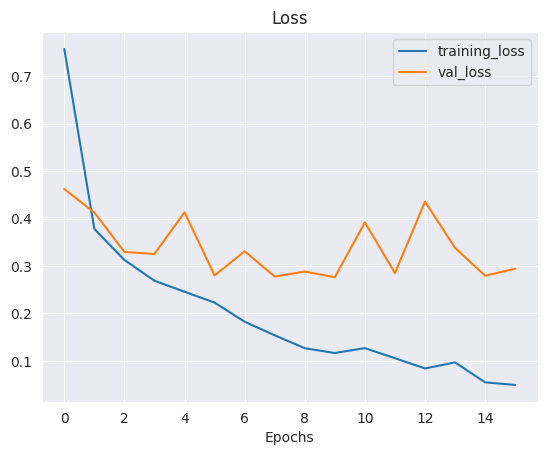

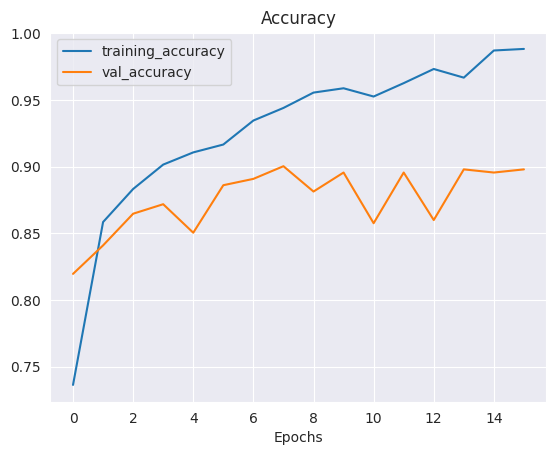

In [91]:
plot_loss_curves(resnet50_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 1s 178ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       106
           1       1.00      1.00      1.00       111
           2       0.81      0.85      0.83       103
           3       0.91      0.86      0.89       108

    accuracy                           0.90       428
   macro avg       0.90      0.90      0.90       428
weighted avg       0.90      0.90      0.90       428

Specificity: [0.281437125748503, 0.3501577287066246, 0.25882352941176473, 0.27761194029850744]
Mean Squared Error: : 0.1067313402891159
The average AUC-ROC is 0.9873708245319135


[0.9627329192546584,
 0.6656151419558359,
 0.6990595611285266,
 0.6809815950920245,
 0.65527950310559,
 1.0,
 0.6520376175548589,
 0.6595092024539877,
 0.7049689440993789,
 0.6750788643533123,
 0.9529780564263323,
 0.7055214723926381,
 0.6770186335403726,
 0.6593059936908517,
 0.6959247648902821,
 0.9539877300613497]

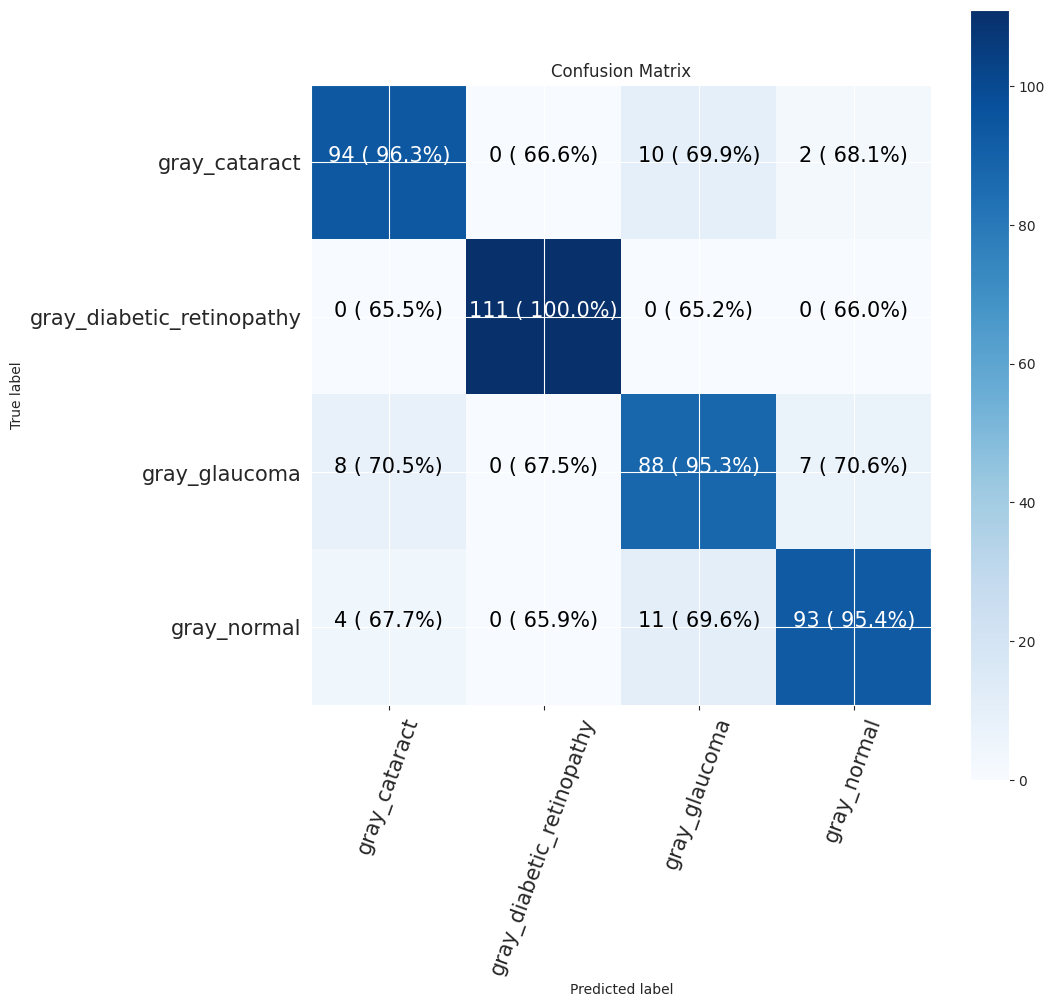

In [92]:
# Save Model
resnet50_model.save("resnet50_model.h5")

model = resnet50_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


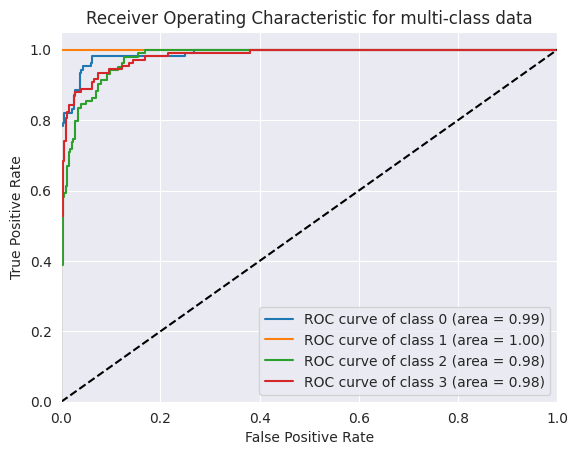

In [93]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet101**

In [94]:
from tensorflow.keras.applications import ResNet101

# Load ResNet-101 without the top classification layers (include_top=False)
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet101_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)

# Convert grayscale to 3 channels (matching the input requirement of ResNet-101)
conv_layer = layers.Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-101 model
x = resnet101_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-101 model for grayscale images
resnet101_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet101_model.summary()


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_17 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_8  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_25 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_26 (Dense)            (None, 4)                 4100      
                                                           

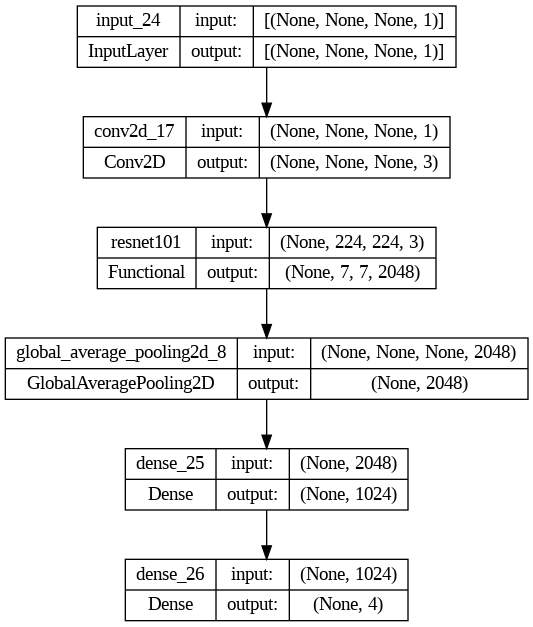

In [95]:
tf.keras.utils.plot_model(resnet101_model, show_shapes=True)

In [96]:
resnet101_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [97]:
resnet101_history= resnet101_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
53/53 [==============================] - 52s 860ms/step - loss: 1.0393 - accuracy: 0.6787 - val_loss: 0.5761 - val_accuracy: 0.7815 - lr: 0.0010
Epoch 2/20
53/53 [==============================] - 43s 811ms/step - loss: 0.4672 - accuracy: 0.8171 - val_loss: 0.4121 - val_accuracy: 0.8337 - lr: 0.0010
Epoch 3/20
53/53 [==============================] - 43s 817ms/step - loss: 0.3747 - accuracy: 0.8483 - val_loss: 0.3456 - val_accuracy: 0.8646 - lr: 0.0010
Epoch 4/20
53/53 [==============================] - 43s 815ms/step - loss: 0.3474 - accuracy: 0.8649 - val_loss: 0.3360 - val_accuracy: 0.8789 - lr: 0.0010
Epoch 5/20
53/53 [==============================] - 43s 816ms/step - loss: 0.3225 - accuracy: 0.8696 - val_loss: 0.3830 - val_accuracy: 0.8527 - lr: 0.0010
Epoch 6/20
53/53 [==============================] - 44s 817ms/step - loss: 0.2918 - accuracy: 0.8814 - val_loss: 0.3243 - val_accuracy: 0.8646 - lr: 0.0010
Epoch 7/20
53/53 [==============================] - 44s 818ms/st

ResNet101 Evaluation

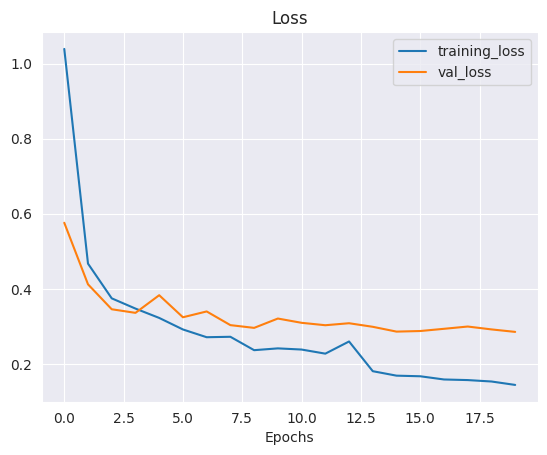

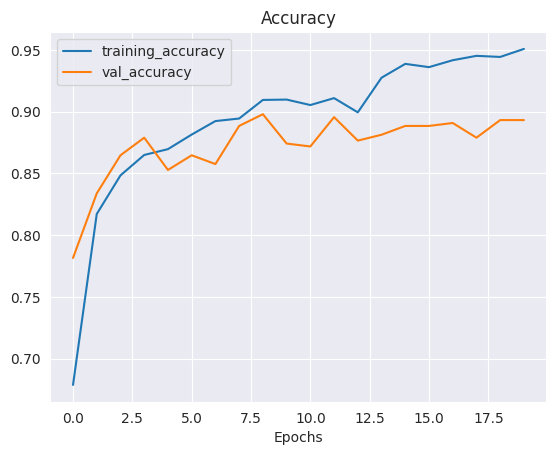

In [98]:
plot_loss_curves(resnet101_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 2s 294ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.92      0.86       106
           1       0.98      1.00      0.99       111
           2       0.78      0.69      0.73       103
           3       0.84      0.81      0.83       108

    accuracy                           0.86       428
   macro avg       0.85      0.85      0.85       428
weighted avg       0.86      0.86      0.86       428

Specificity: [0.2930513595166163, 0.3501577287066246, 0.19887955182072828, 0.25882352941176473]
Mean Squared Error: : 0.11326588690280914
The average AUC-ROC is 0.9764322523686941


[0.970873786407767,
 0.6634920634920635,
 0.7032640949554896,
 0.6811145510835913,
 0.6407766990291263,
 1.0,
 0.6706231454005934,
 0.6563467492260062,
 0.7216828478964401,
 0.6761904761904762,
 0.9050445103857567,
 0.7244582043343654,
 0.6666666666666666,
 0.6603174603174603,
 0.7210682492581603,
 0.9380804953560371]

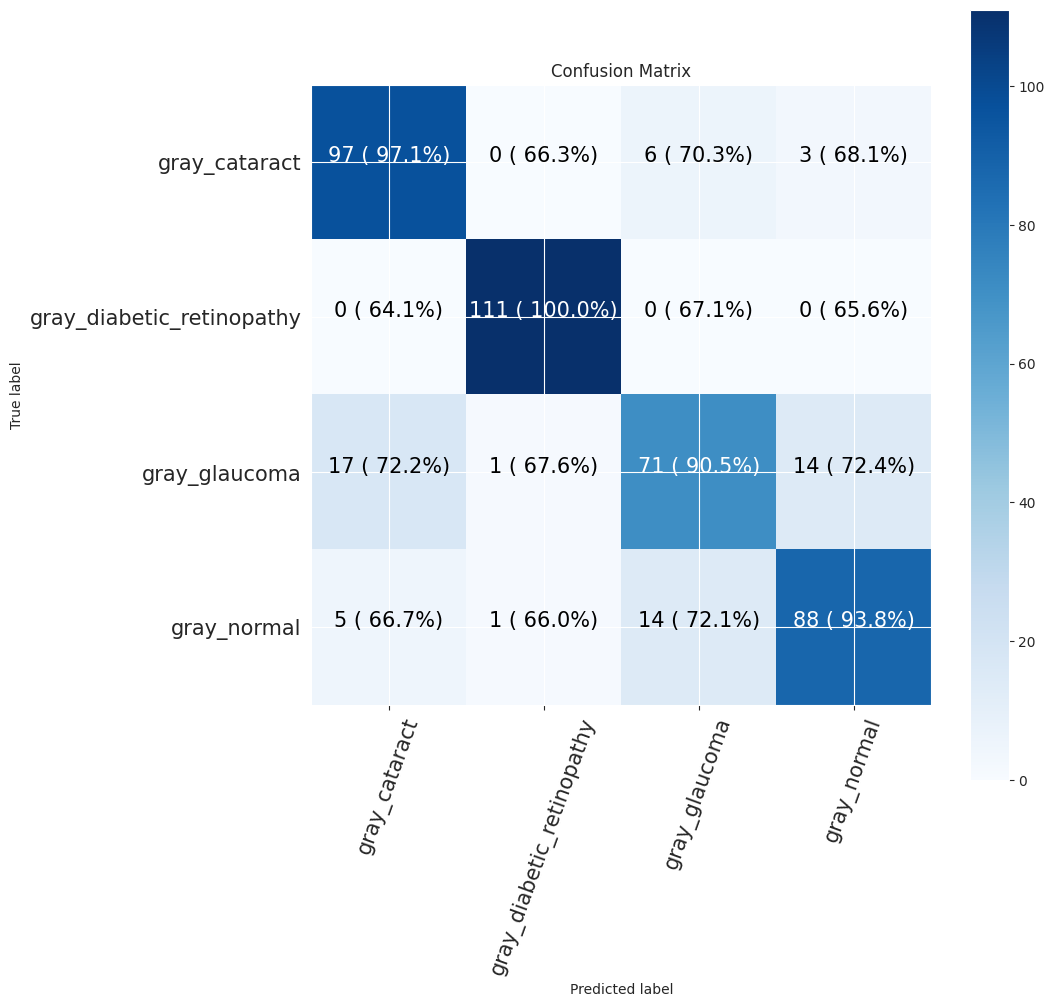

In [99]:
# Save Model
resnet101_model.save("resnet101_model.h5")

model = resnet101_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


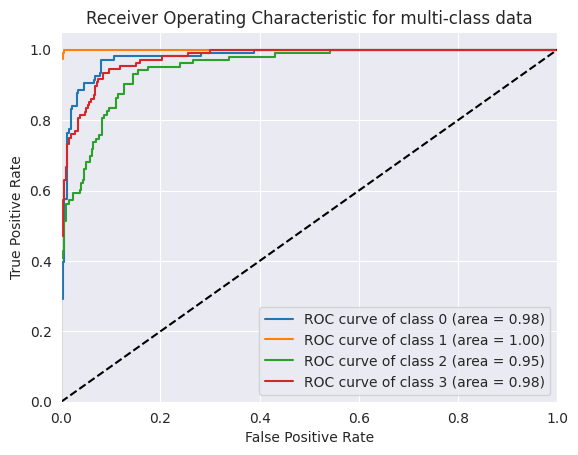

In [100]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()